**Description:** We want to use different ML (supervised and unsupervised) approaches to predict churns of subscriptions of the german newspaper “Die Zeit”. Supervised ML methods can be used to predict (classification methods) subscription churns based on the given dataset. Since a large number of features exists, feature selection as part of an extensive EDA is essential. Unsupervised ML methods could be used first to do clustering on the dataset to identify if there are certain “groups of subscribers”, who share certain features. This clustering could be used to investigate subscriber group specific churn mitigation methods (not only writing emails, as given in the dataset description).

**Project Name:** Churn Prediction - Die Zeit

**Team:** Carlotta Ulm, Silas Mederer, Jonas Bechthold

**Date:** 2020-10-26 to 2020-11-27

# Setting up environment and imports

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import math
import itertools
from time import time

# own modules
import eda_methods as eda

# visualization
import seaborn as sns
#sns.set(style="white")  
sns.set_theme()

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from pandas.plotting import scatter_matrix

# pandas profiling
from pandas_profiling import ProfileReport

# warnings handler
import warnings
warnings.filterwarnings("ignore")

random_state = 100           # Ensures modeling results can be replicated
np.random.seed(42)

# Display Options for pandas
pd.set_option('display.max_columns', None) # Sets maximum columns displayed in tables
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

# Variables for plot sizes
matplotlib.rc('font', size=20)          # controls default text sizes
matplotlib.rc('axes', titlesize=16)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=18)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=18)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=18)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=14)    # legend fontsize
matplotlib.rc('figure', titlesize=20)

####################################################
# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer 
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#geodaten
import geopandas as gpd

# Business Understanding 

Please check the [wiki page: Business understanding (publishing and news)](https://github.com/jb-ds2020/nf-ds3-capstone-churn-prevention/wiki/Business-understanding-(publishing-and-news)).

## Dataset Description

Let's get an idea about the columns and find out what they mean.

In [2]:
# new dataframe 2
df = pd.read_csv('data/f_chtr_churn_traintable_nf_2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209043 entries, 0 to 209042
Columns: 171 entries, Unnamed: 0 to date_x
dtypes: float64(32), int64(121), object(18)
memory usage: 272.7+ MB


In [3]:
df.head()

,Unnamed: 0,auftrag_new_id,liefer_beginn_evt,kanal,objekt_name,aboform_name,zahlung_rhythmus_name,lesedauer,rechnungsmonat,zahlung_weg_name,studentenabo,plz_1,plz_2,plz_3,ort,metropole,land_iso_code,shop_kauf,unterbrechung,anrede,titel,avg_churn,email_am_kunden,zon_che_opt_in,zon_sit_opt_in,zon_zp_grey,zon_premium,zon_boa,zon_kommentar,zon_sonstige,zon_zp_red,zon_rawr,zon_community,zon_app_sonstige,zon_schach,zon_blog_kommentare,zon_quiz,cnt_abo,cnt_abo_diezeit,cnt_abo_diezeit_digital,cnt_abo_magazin,cnt_umwandlungsstatus2_dkey,abo_registrierung_min,nl_zeitbrief,nl_zeitshop,nl_zeitverlag_hamburg,nl_fdz_organisch,nl_blacklist_sum,nl_bounced_sum,nl_aktivitaet,nl_registrierung_min,nl_sperrliste_sum,nl_opt_in_sum,boa_reg,che_reg,sit_reg,sso_reg,received_anzahl_1w,received_anzahl_1m,received_anzahl_3m,received_anzahl_6m,opened_anzahl_1w,opened_anzahl_1m,opened_anzahl_3m,openedanzahl_6m,clicked_anzahl_1w,clicked_anzahl_1m,clicked_anzahl_3m,clicked_anzahl_6m,unsubscribed_anzahl_1w,unsubscribed_anzahl_1m,unsubscribed_anzahl_3m,unsubscribed_anzahl_6m,openrate_1w,clickrate_1w,openrate_1m,clickrate_1m,openrate_3m,clickrate_3m,received_anzahl_bestandskunden_1w,received_anzahl_bestandskunden_1m,received_anzahl_bestandskunden_3m,received_anzahl_bestandskunden_6m,opened_anzahl_bestandskunden_1w,opened_anzahl_bestandskunden_1m,opened_anzahl_bestandskunden_3m,openedanzahl_bestandskunden_6m,clicked_anzahl_bestandskunden_1w,clicked_anzahl_bestandskunden_1m,clicked_anzahl_bestandskunden_3m,clicked_anzahl_bestandskunden_6m,unsubscribed_anzahl_bestandskunden_1w,unsubscribed_anzahl_bestandskunden_1m,unsubscribed_anzahl_bestandskunden_3m,unsubscribed_anzahl_bestandskunden_6m,openrate_bestandskunden_1w,clickrate_bestandskunden_1w,openrate_bestandskunden_1m,clickrate_bestandskunden_1m,openrate_bestandskunden_3m,clickrate_bestandskunden_3m,received_anzahl_produktnews_1w,received_anzahl_produktnews_1m,received_anzahl_produktnews_3m,received_anzahl_produktnews_6m,opened_anzahl_produktnews_1w,opened_anzahl_produktnews_1m,opened_anzahl_produktnews_3m,openedanzahl_produktnews_6m,clicked_anzahl_produktnews_1w,clicked_anzahl_produktnews_1m,clicked_anzahl_produktnews_3m,clicked_anzahl_produktnews_6m,unsubscribed_anzahl_produktnews_1w,unsubscribed_anzahl_produktnews_1m,unsubscribed_anzahl_produktnews_3m,unsubscribed_anzahl_produktnews_6m,openrate_produktnews_1w,clickrate_produktnews_1w,openrate_produktnews_1m,clickrate_produktnews_1m,openrate_produktnews_3m,clickrate_produktnews_3m,received_anzahl_hamburg_1w,received_anzahl_hamburg_1m,received_anzahl_hamburg_3m,received_anzahl_hamburg_6m,opened_anzahl_hamburg_1w,opened_anzahl_hamburg_1m,opened_anzahl_hamburg_3m,openedanzahl_hamburg_6m,clicked_anzahl_hamburg_1w,clicked_anzahl_hamburg_1m,clicked_anzahl_hamburg_3m,clicked_anzahl_hamburg_6m,unsubscribed_anzahl_hamburg_1w,unsubscribed_anzahl_hamburg_1m,unsubscribed_anzahl_hamburg_3m,unsubscribed_anzahl_hamburg_6m,openrate_hamburg_1w,clickrate_hamburg_1w,openrate_hamburg_1m,clickrate_hamburg_1m,openrate_hamburg_3m,clickrate_hamburg_3m,received_anzahl_zeitbrief_1w,received_anzahl_zeitbrief_1m,received_anzahl_zeitbrief_3m,received_anzahl_zeitbrief_6m,opened_anzahl_zeitbrief_1w,opened_anzahl_zeitbrief_1m,opened_anzahl_zeitbrief_3m,openedanzahl_zeitbrief_6m,clicked_anzahl_zeitbrief_1w,clicked_anzahl_zeitbrief_1m,clicked_anzahl_zeitbrief_3m,clicked_anzahl_zeitbrief_6m,unsubscribed_anzahl_zeitbrief_1w,unsubscribed_anzahl_zeitbrief_1m,unsubscribed_anzahl_zeitbrief_3m,unsubscribed_anzahl_zeitbrief_6m,openrate_zeitbrief_1w,clickrate_zeitbrief_1w,openrate_zeitbrief_1m,clickrate_zeitbrief_1m,openrate_zeitbrief_3m,clickrate_zeitbrief_3m,training_set,kuendigungs_eingangs_datum,churn,date_x
0,0,6BE5B590-07EA-4543-B422-F7ABB2AF9464,2013-10-02,andere,ZEIT Digital,Probeabo,jährlich,68,0,Bankeinzug,0,6,64,647,Erbach,0,DE,4,0,Frau,akademischer Titel,0.133879,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2,0,2,2,2005-01-27 07:53:59,2,2,0,0,0,1,14,2005-09-30 00:00:00,0,0,0,0,0,1,6,14,43,80,4,15,38,74

In [4]:
df.tail(1)

,Unnamed: 0,auftrag_new_id,liefer_beginn_evt,kanal,objekt_name,aboform_name,zahlung_rhythmus_name,lesedauer,rechnungsmonat,zahlung_weg_name,studentenabo,plz_1,plz_2,plz_3,ort,metropole,land_iso_code,shop_kauf,unterbrechung,anrede,titel,avg_churn,email_am_kunden,zon_che_opt_in,zon_sit_opt_in,zon_zp_grey,zon_premium,zon_boa,zon_kommentar,zon_sonstige,zon_zp_red,zon_rawr,zon_community,zon_app_sonstige,zon_schach,zon_blog_kommentare,zon_quiz,cnt_abo,cnt_abo_diezeit,cnt_abo_diezeit_digital,cnt_abo_magazin,cnt_umwandlungsstatus2_dkey,abo_registrierung_min,nl_zeitbrief,nl_zeitshop,nl_zeitverlag_hamburg,nl_fdz_organisch,nl_blacklist_sum,nl_bounced_sum,nl_aktivitaet,nl_registrierung_min,nl_sperrliste_sum,nl_opt_in_sum,boa_reg,che_reg,sit_reg,sso_reg,received_anzahl_1w,received_anzahl_1m,received_anzahl_3m,received_anzahl_6m,opened_anzahl_1w,opened_anzahl_1m,opened_anzahl_3m,openedanzahl_6m,clicked_anzahl_1w,clicked_anzahl_1m,clicked_anzahl_3m,clicked_anzahl_6m,unsubscribed_anzahl_1w,unsubscribed_anzahl_1m,unsubscribed_anzahl_3m,unsubscribed_anzahl_6m,openrate_1w,clickrate_1w,openrate_1m,clickrate_1m,openrate_3m,clickrate_3m,received_anzahl_bestandskunden_1w,received_anzahl_bestandskunden_1m,received_anzahl_bestandskunden_3m,received_anzahl_bestandskunden_6m,opened_anzahl_bestandskunden_1w,opened_anzahl_bestandskunden_1m,opened_anzahl_bestandskunden_3m,openedanzahl_bestandskunden_6m,clicked_anzahl_bestandskunden_1w,clicked_anzahl_bestandskunden_1m,clicked_anzahl_bestandskunden_3m,clicked_anzahl_bestandskunden_6m,unsubscribed_anzahl_bestandskunden_1w,unsubscribed_anzahl_bestandskunden_1m,unsubscribed_anzahl_bestandskunden_3m,unsubscribed_anzahl_bestandskunden_6m,openrate_bestandskunden_1w,clickrate_bestandskunden_1w,openrate_bestandskunden_1m,clickrate_bestandskunden_1m,openrate_bestandskunden_3m,clickrate_bestandskunden_3m,received_anzahl_produktnews_1w,received_anzahl_produktnews_1m,received_anzahl_produktnews_3m,received_anzahl_produktnews_6m,opened_anzahl_produktnews_1w,opened_anzahl_produktnews_1m,opened_anzahl_produktnews_3m,openedanzahl_produktnews_6m,clicked_anzahl_produktnews_1w,clicked_anzahl_produktnews_1m,clicked_anzahl_produktnews_3m,clicked_anzahl_produktnews_6m,unsubscribed_anzahl_produktnews_1w,unsubscribed_anzahl_produktnews_1m,unsubscribed_anzahl_produktnews_3m,unsubscribed_anzahl_produktnews_6m,openrate_produktnews_1w,clickrate_produktnews_1w,openrate_produktnews_1m,clickrate_produktnews_1m,openrate_produktnews_3m,clickrate_produktnews_3m,received_anzahl_hamburg_1w,received_anzahl_hamburg_1m,received_anzahl_hamburg_3m,received_anzahl_hamburg_6m,opened_anzahl_hamburg_1w,opened_anzahl_hamburg_1m,opened_anzahl_hamburg_3m,openedanzahl_hamburg_6m,clicked_anzahl_hamburg_1w,clicked_anzahl_hamburg_1m,clicked_anzahl_hamburg_3m,clicked_anzahl_hamburg_6m,unsubscribed_anzahl_hamburg_1w,unsubscribed_anzahl_hamburg_1m,unsubscribed_anzahl_hamburg_3m,unsubscribed_anzahl_hamburg_6m,openrate_hamburg_1w,clickrate_hamburg_1w,openrate_hamburg_1m,clickrate_hamburg_1m,openrate_hamburg_3m,clickrate_hamburg_3m,received_anzahl_zeitbrief_1w,received_anzahl_zeitbrief_1m,received_anzahl_zeitbrief_3m,received_anzahl_zeitbrief_6m,opened_anzahl_zeitbrief_1w,opened_anzahl_zeitbrief_1m,opened_anzahl_zeitbrief_3m,openedanzahl_zeitbrief_6m,clicked_anzahl_zeitbrief_1w,clicked_anzahl_zeitbrief_1m,clicked_anzahl_zeitbrief_3m,clicked_anzahl_zeitbrief_6m,unsubscribed_anzahl_zeitbrief_1w,unsubscribed_anzahl_zeitbrief_1m,unsubscribed_anzahl_zeitbrief_3m,unsubscribed_anzahl_zeitbrief_6m,openrate_zeitbrief_1w,clickrate_zeitbrief_1w,openrate_zeitbrief_1m,clickrate_zeitbrief_1m,openrate_zeitbrief_3m,clickrate_zeitbrief_3m,training_set,kuendigungs_eingangs_datum,churn,date_x
209042,209042,46A87B9A-2B53-4303-A401-33E3F3E622CA,2019-03-28,andere,DIE ZEIT,Negative Option,halbjährlich,7,0,Rechnung,0,6,67,670,Bad Dürkheim,0,DE,0,0,Herr,sonstiger Titel,0.643506,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,4,2,0,1,2008-04-16 10:46:45,2,0,0,0,0,0,6,2008-08-13 14:16:43,0,0,0,0,0,1,2,11,

In [5]:
df.drop(["Unnamed: 0","auftrag_new_id"], axis=1, inplace=True)

In [6]:
eda.describe_plus(df).round(2)

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis,variance
lesedauer,209043.0,32.05,21.56,0.0,14.00,27.00,47.00,88.00,0.69,-0.57,464.71
rechnungsmonat,209043.0,0.10,0.30,0.0,0.00,0.00,0.00,1.00,2.65,5.03,0.09
studentenabo,209043.0,0.11,0.31,0.0,0.00,0.00,0.00,1.00,2.49,4.22,0.10
metropole,209043.0,0.29,0.46,0.0,0.00,0.00,1.00,1.00,0.91,-1.18,0.21
shop_kauf,209043.0,0.54,2.47,0.0,0.00,0.00,0.00,152.00,14.98,503.79,6.09
unterbrechung,209043.0,0.10,0.30,0.0,0.00,0.00,0.00,1.00,2.64,4.95,0.09
avg_churn,209043.0,0.31,0.15,0.1,0.18,0.29,0.41,0.70,0.69,-0.33,0.02
email_am_kunden,209031.0,0.94,0.25,0.0,1.00,1.00,1.00,1.00,-3.55,10.62,0.06
zon_che_opt_in,209043.0,0.00,0.05,0.0,0.00,0.00,0.00,2.00,27.52,841.32,0.00
zon_sit_opt_in,209043.0,0.00,0.03,0.0,0.00,0.00,0.00,2.00,41.15,1899.34,0.00


## Get an idea of the column names by sampling

In [7]:
df.sample(2)

,liefer_beginn_evt,kanal,objekt_name,aboform_name,zahlung_rhythmus_name,lesedauer,rechnungsmonat,zahlung_weg_name,studentenabo,plz_1,plz_2,plz_3,ort,metropole,land_iso_code,shop_kauf,unterbrechung,anrede,titel,avg_churn,email_am_kunden,zon_che_opt_in,zon_sit_opt_in,zon_zp_grey,zon_premium,zon_boa,zon_kommentar,zon_sonstige,zon_zp_red,zon_rawr,zon_community,zon_app_sonstige,zon_schach,zon_blog_kommentare,zon_quiz,cnt_abo,cnt_abo_diezeit,cnt_abo_diezeit_digital,cnt_abo_magazin,cnt_umwandlungsstatus2_dkey,abo_registrierung_min,nl_zeitbrief,nl_zeitshop,nl_zeitverlag_hamburg,nl_fdz_organisch,nl_blacklist_sum,nl_bounced_sum,nl_aktivitaet,nl_registrierung_min,nl_sperrliste_sum,nl_opt_in_sum,boa_reg,che_reg,sit_reg,sso_reg,received_anzahl_1w,received_anzahl_1m,received_anzahl_3m,received_anzahl_6m,opened_anzahl_1w,opened_anzahl_1m,opened_anzahl_3m,openedanzahl_6m,clicked_anzahl_1w,clicked_anzahl_1m,clicked_anzahl_3m,clicked_anzahl_6m,unsubscribed_anzahl_1w,unsubscribed_anzahl_1m,unsubscribed_anzahl_3m,unsubscribed_anzahl_6m,openrate_1w,clickrate_1w,openrate_1m,clickrate_1m,openrate_3m,clickrate_3m,received_anzahl_bestandskunden_1w,received_anzahl_bestandskunden_1m,received_anzahl_bestandskunden_3m,received_anzahl_bestandskunden_6m,opened_anzahl_bestandskunden_1w,opened_anzahl_bestandskunden_1m,opened_anzahl_bestandskunden_3m,openedanzahl_bestandskunden_6m,clicked_anzahl_bestandskunden_1w,clicked_anzahl_bestandskunden_1m,clicked_anzahl_bestandskunden_3m,clicked_anzahl_bestandskunden_6m,unsubscribed_anzahl_bestandskunden_1w,unsubscribed_anzahl_bestandskunden_1m,unsubscribed_anzahl_bestandskunden_3m,unsubscribed_anzahl_bestandskunden_6m,openrate_bestandskunden_1w,clickrate_bestandskunden_1w,openrate_bestandskunden_1m,clickrate_bestandskunden_1m,openrate_bestandskunden_3m,clickrate_bestandskunden_3m,received_anzahl_produktnews_1w,received_anzahl_produktnews_1m,received_anzahl_produktnews_3m,received_anzahl_produktnews_6m,opened_anzahl_produktnews_1w,opened_anzahl_produktnews_1m,opened_anzahl_produktnews_3m,openedanzahl_produktnews_6m,clicked_anzahl_produktnews_1w,clicked_anzahl_produktnews_1m,clicked_anzahl_produktnews_3m,clicked_anzahl_produktnews_6m,unsubscribed_anzahl_produktnews_1w,unsubscribed_anzahl_produktnews_1m,unsubscribed_anzahl_produktnews_3m,unsubscribed_anzahl_produktnews_6m,openrate_produktnews_1w,clickrate_produktnews_1w,openrate_produktnews_1m,clickrate_produktnews_1m,openrate_produktnews_3m,clickrate_produktnews_3m,received_anzahl_hamburg_1w,received_anzahl_hamburg_1m,received_anzahl_hamburg_3m,received_anzahl_hamburg_6m,opened_anzahl_hamburg_1w,opened_anzahl_hamburg_1m,opened_anzahl_hamburg_3m,openedanzahl_hamburg_6m,clicked_anzahl_hamburg_1w,clicked_anzahl_hamburg_1m,clicked_anzahl_hamburg_3m,clicked_anzahl_hamburg_6m,unsubscribed_anzahl_hamburg_1w,unsubscribed_anzahl_hamburg_1m,unsubscribed_anzahl_hamburg_3m,unsubscribed_anzahl_hamburg_6m,openrate_hamburg_1w,clickrate_hamburg_1w,openrate_hamburg_1m,clickrate_hamburg_1m,openrate_hamburg_3m,clickrate_hamburg_3m,received_anzahl_zeitbrief_1w,received_anzahl_zeitbrief_1m,received_anzahl_zeitbrief_3m,received_anzahl_zeitbrief_6m,opened_anzahl_zeitbrief_1w,opened_anzahl_zeitbrief_1m,opened_anzahl_zeitbrief_3m,openedanzahl_zeitbrief_6m,clicked_anzahl_zeitbrief_1w,clicked_anzahl_zeitbrief_1m,clicked_anzahl_zeitbrief_3m,clicked_anzahl_zeitbrief_6m,unsubscribed_anzahl_zeitbrief_1w,unsubscribed_anzahl_zeitbrief_1m,unsubscribed_anzahl_zeitbrief_3m,unsubscribed_anzahl_zeitbrief_6m,openrate_zeitbrief_1w,clickrate_zeitbrief_1w,openrate_zeitbrief_1m,clickrate_zeitbrief_1m,openrate_zeitbrief_3m,clickrate_zeitbrief_3m,training_set,kuendigungs_eingangs_datum,churn,date_x
130814,2018-07-25,andere,ZEIT Digital,Festabo,jährlich,19,0,Bankeinzug,0,6,69,692,Sandhausen,0,DE,0,0,Frau,kein Titel,0.210329,1.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,2018-06-15 03:34:30,2,0,0,0,0,0,7,2018-06-13 13:57:07,0,0,0,0,0,1,2,9,28,58,0,0,3,8,0,0,1,4,0,0,0,0,0.0,0.0,0.0,0.0,0.11,0.33,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## Dataset Overview with pandas profiling

Profile for new dataframe

In [8]:
# use pandas_profiling to create report
# save html to plots

# profile = ProfileReport(df)
# profile.to_file("plots/report.html")

In [9]:
from IPython.display import IFrame
IFrame(src='plots/pandas_profiling_report.html', width=1000, height=700)

# Data Editing

We reduce the number of cnt_abo maximum to 5 (maximum number of abos per customer, digital, print and magazines), see [Business Understanding](https://github.com/jb-ds2020/nf-ds3-capstone-churn-prevention/wiki/Business-understanding-(publishing-and-news)).

In [68]:
df = df[df.cnt_abo < 5]

# Data Cleaning
Purpose: Fix the inconsistencies within the data and handle the missing values

In [10]:
null_rel = round(df.isin([0]).sum() / df.shape[0]*100,2)
null_rel = null_rel.to_frame()
null_rel.rename(columns={0: "zeros %"}, inplace=True)
eda.meta(df).T.join(null_rel).head(5)

,nulls,percent,dtype,dup,nuniques,zeros %
varname,,,,,,
kuendigungs_eingangs_datum,142754,68.29,object,True,349,0.00
ort,85,0.04,object,True,11475,0.00
email_am_kunden,12,0.01,float64,True,2,6.43
liefer_beginn_evt,0,0,object,True,406,0.00
clicked_anzahl_produktnews_3m,0,0,int64,True,9,97.42


In [11]:
# numeric and categorical features
print(f"shape {df.shape}")
continues = df.select_dtypes(include=['float64','int64'])
print(f"numeric features {len(continues.columns)}")
categorial = df.select_dtypes(include="object")
print(f"object features  {len(categorial.columns)}")

shape (209043, 169)
numeric features 152
object features  17


Now we delete the null/missing values.

In [13]:
df.dropna(subset=['ort','email_am_kunden'], inplace=True)

In [14]:
null_rel = round(df.isin([0]).sum() / df.shape[0]*100,2)
null_rel = null_rel.to_frame()
null_rel.rename(columns={0: "zeros  %"}, inplace=True)
eda.meta(df).T.join(null_rel).head(5)

,nulls,percent,dtype,dup,nuniques,zeros %
varname,,,,,,
kuendigungs_eingangs_datum,142728,68.3,object,True,349,0.00
liefer_beginn_evt,0,0,object,True,406,0.00
clickrate_produktnews_1w,0,0,float64,True,7,99.67
clicked_anzahl_produktnews_1m,0,0,int64,True,6,98.77
clicked_anzahl_produktnews_3m,0,0,int64,True,9,97.42


## Conclusion

**Dataframe in general**
- The data set is complete and contains 161,760 entries and 169 features. There are some features that we will not be able to use. For example the label "churn" or the feature "date_x", "kuendigungs_eingangs_datum" or "avg_churn" which probably contains the values from the current churn-prediction-model.

**Missings**
- There are only two features with missing values. The feature "kuendigungs_eingangs_datum" is null if there is no notice of termination, so these nulls are correct. The missing values of ort and email_am_kunden have been dropped.

**Dublicates**
- The feature "auftrag_new_id" is the only one with no dublicates. We will drop this, cause all these entries are unique given by the stakeholder to manage the contracts.

**Data types**
- There are 151 numeric features, a lot of them will be categorial. Also we have 18 object types.

**Zero Values**
- As you can see a lot of the features contain high percentage of "0" values. "zon_community" for example is 100.00% altought it has 3 nunique values. This is an example of how little elements have the nunique characteristic.

# Data Exploration - EDA


In [15]:
def crosstab_evaluation(feature_column,target_column,relative=True):
    '''function to cross evaluate two features by a pandas cross table
    Inputs:
    feature_column: pandas Series of feature
    target_column: pandas Series of target (y-axis value)
    relative: False -> returns absolute values, True -> gives percentages
    
    Return:
    crosstable
    '''
    crosstable = pd.crosstab(feature_column,target_column)
    if relative:
        crosstable = crosstable.div(crosstable.sum(1),axis=0)
    
    return crosstable

def crosstab_barplot(crosstable,labellist,figsize_x=10,figsize_y=7,xlabelname='Default'):
    '''
    Function to plot a pandas crosstable. 
    
    Inputs:
    crosstable: a pandas crosstable
    labellist: a list with the labels of the data
    xlabelname: Name of the x axis feature
    '''
    crosstable.plot(kind='bar', stacked=True,figsize=(figsize_x,figsize_y))
    plt.xlabel(xlabelname)
    plt.ylabel('Frequency')
    
    #plt.title('Title');
    #plt.xticks(np.arange(2), ('60 months', '36 months',), fontsize=20)
    
    L=plt.legend(fontsize=20,loc=(1.04,0.83))
    L.get_texts()[0].set_text(labellist[0])
    L.get_texts()[1].set_text(labellist[1])

## Describe

In [17]:
eda.describe_plus(df).head()

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis,variance
lesedauer,208958.0,32.05,21.56,0.0,14.0,27.0,47.0,88.0,0.69,-0.57,464.70
rechnungsmonat,208958.0,0.10,0.30,0.0,0.0,0.0,0.0,1.0,2.65,5.04,0.09
studentenabo,208958.0,0.11,0.31,0.0,0.0,0.0,0.0,1.0,2.49,4.22,0.10
metropole,208958.0,0.29,0.46,0.0,0.0,0.0,1.0,1.0,0.91,-1.18,0.21
shop_kauf,208958.0,0.54,2.47,0.0,0.0,0.0,0.0,152.0,14.98,503.60,6.09


## Customer/Personal Features

The following feature are considered as personal information and shortly described:
- anrede: Mr, Mrs
- titel: academic title
- plz_1: first letter of zip code
- plz_2: first two letters of zip code
- plz_3: first three letters of zip code
- ort: city
- metropole: is the city a metropolitan city
- land_iso_code: DE, A, CH (Germany, Austria, Switzerland)

### Anrede

In [ ]:
legendlist = ['churn','no churn']

In [ ]:
df.anrede.value_counts().plot(kind='bar');

In [ ]:
anrede_churn = crosstab_evaluation(df.anrede,df.churn)
crosstab_barplot(anrede_churn,['no churn','churn'],xlabelname='Anrede')

We can observe just small differences in the anrede, unknown and male customers seem to have a slightly higher churn probability. 

### Titel

In [ ]:
df.titel.value_counts().plot(kind='bar');

In [ ]:
titel_churn = crosstab_evaluation(df.titel,df.churn)
crosstab_barplot(titel_churn,['no churn','churn'],xlabelname='Titel')

We can observer a smaller churn rate for academic titles compared to no title. The column other title (sonstiger Titel) is quite useless because we don't know hat kind of titles are included in there.

### PLZ 1 

Find the missing number of zip codes:

In [ ]:
df_zip_xx = df[df.plz_1 == 'xx']
print('Number of missing zip codes entries:',df_zip_xx.shape[0])
print('Percentage of missing zip codes in total:',df_zip_xx.shape[0]/df.shape[0])

There are 19788 entries with no zip code, which is about 12 percent. 

In [ ]:
df_zip_xx.ort.value_counts().nlargest(10)

The xx zip codes are all non german cities (e.g. Switzerland), so we could divide the dataset into germany and out of germany areas.

In [ ]:
plz1_churn = crosstab_evaluation(df.plz_1,df.churn)
crosstab_barplot(plz1_churn,['churn','no churn'],xlabelname='PLZ 1')

Simplified geographic features, here the first digit of the zip code are quite uselfull indicators for determine regions with higher churn rate. 

### PLZ 2

In [ ]:
plz2_churn = crosstab_evaluation(df.plz_2,df.churn)
crosstab_barplot(plz2_churn,['churn','no churn'],xlabelname='PLZ 2',figsize_x=25)

Compated to plz_1 we can see more details by this geographic information, the smearing of geographical data is less with two digits and we can have nice insights in the geographical distribution of our churns.

### PLZ 3

In [ ]:
plz3_churn = crosstab_evaluation(df.plz_3,df.churn)
crosstab_barplot(plz3_churn,['no churn','churn'],xlabelname='PLZ 3',figsize_x=50)
plt.xlim(0,50);

By using the 3 digit PLZ we can observe much higher variations in the churn rate. We should definitely include this feature in our model.

Since this feature has a lot of entries, it is usefull to use a nice geographical visualization with geopandas. The link to geopandas for germany can be found here: https://juanitorduz.github.io/germany_plots/

In [ ]:
# geodata
plz_shape_df = gpd.read_file('data/plz-gebiete.shp', dtype={'plz': str})

plz_shape_df.info()

In [ ]:
top_cities = {
    'Berlin': (13.404954, 52.520008), 
    'Cologne': (6.953101, 50.935173),
    'Düsseldorf': (6.782048, 51.227144),
    'Frankfurt am Main': (8.682127, 50.110924),
    'Hamburg': (9.993682, 53.551086),
    'Leipzig': (12.387772, 51.343479),
    'Munich': (11.576124, 48.137154),
    'Dortmund': (7.468554, 51.513400),
    'Stuttgart': (9.181332, 48.777128),
    'Nuremberg': (11.077438, 49.449820),
    'Hannover': (9.73322, 52.37052)
}

In [ ]:
plz_region_df = pd.read_csv(
    'data/zuordnung_plz_ort.csv', 
    sep=',', 
    dtype={'plz': str}
)

plz_region_df.drop('osm_id', axis=1, inplace=True)

plz_region_df.head()

In [ ]:
# Merge data.
germany_df = pd.merge(
    left=plz_shape_df, 
    right=plz_region_df, 
    on='plz',
    how='inner'
)

germany_df.drop(['note'], axis=1, inplace=True)

Mapping Functions to map churn probabilities for each subset of plz digits into a dataframe. 

In [ ]:
def convert_plz_1_to_prob(plz):
    index = str(plz)[0]
    #print(index)
    value = plz1_churn.iloc[int(index),1]
    return value

def convert_plz_2_to_prob(plz):
    index = str(plz)[0:2]
    #print(index)
    value = plz2_churn[plz2_churn.index == index].iloc[0,1]
    #print(value)
    return value

def convert_plz_3_to_prob(plz):
    index = str(plz)[0:3]
    #print(index)
    value = plz3_churn[plz3_churn.index == index].iloc[0,1]
    #print(value)
    return value

In [ ]:
germany_df['churn_plz_1'] = germany_df.plz.apply(lambda x: convert_plz_1_to_prob(x))

In [ ]:
germany_df['churn_plz_2'] = germany_df.plz.apply(lambda x: convert_plz_2_to_prob(x))

In [ ]:
germany_df['churn_plz_3'] = germany_df.plz.apply(lambda x: convert_plz_3_to_prob(x))

Include the number of inhabitants in the dataframe:

In [ ]:
plz_einwohner_df = pd.read_csv(
    'data/plz_einwohner.csv', 
    sep=',', 
    dtype={'plz': str, 'einwohner': int}
)

plz_einwohner_df.head()

In [ ]:
# Merge data.
germany_df = pd.merge(
    left=germany_df, 
    right=plz_einwohner_df, 
    on='plz',
    how='left'
)

#germany_df.head()

In [ ]:
fig, ax = plt.subplots(figsize=(11,16))

germany_df.plot(
    ax=ax, 
    column='churn_plz_1', 
    categorical=False, 
    legend=True, 
    cmap='jet',
    alpha=0.8,

)

for c in top_cities.keys():

    ax.text(
        x=top_cities[c][0], 
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )

    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )
    
ax.set(
    title='Germany: Churn Rate of first digit plz', 
    aspect=1.5, 
    facecolor='lightblue'
);
fig.savefig('plots/churn_rate_landscape_plz_1_digit.png',dpi=300)

We can now visually see the higher churn rate in the eastern part of Germany. 

In [ ]:
fig, ax = plt.subplots(figsize=(11,16))

germany_df.plot(
    ax=ax, 
    column='churn_plz_2', 
    categorical=False, 
    legend=True, 
    cmap='jet',
    alpha=0.8,

)

for c in top_cities.keys():

    ax.text(
        x=top_cities[c][0], 
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )

    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )
    
ax.set(
    title='Germany: Churn Rate of first two digit plz', 
    aspect=1.5, 
    facecolor='lightblue'
);
fig.savefig('plots/churn_rate_landscape_plz_2_digit.png',dpi=300)

Now we can more clearly see some smaller regions with much lower and much higher churn rates.

In [ ]:
fig, ax = plt.subplots(figsize=(11,16))

germany_df.plot(
    ax=ax, 
    column='churn_plz_3', 
    categorical=False, 
    legend=True, 
    cmap='jet',
    alpha=0.8,

)

for c in top_cities.keys():

    ax.text(
        x=top_cities[c][0], 
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )

    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )
    
ax.set(
    title='Germany: Churn Rate of first three digit plz', 
    aspect=1.5, 
    facecolor='lightblue'
);
fig.savefig('plots/churn_rate_landscape_plz_3_digit.png',dpi=300)

This gives us a very detailled overview of the geographical distribution of the churn rate, with much less flattening of the data. We can observe areas with almost zero churn rate and regions with more than 60 percent churn rate.  

### Metropole

In [ ]:
metropole_churn = crosstab_evaluation(df.metropole,df.churn)
crosstab_barplot(metropole_churn,['no churn','churn'],xlabelname='metropole')

No significant influence if either a metropolitan city or not is found. 

### Land iso code

In [ ]:
land_iso_churn = crosstab_evaluation(df.land_iso_code,df.churn)
crosstab_barplot(land_iso_churn,['no churn','churn'],xlabelname='land')

Germany has the highest churn rate, people from abroad (Austria (AT), Switzerland (CH) and other countries abroad) tend to churn with a lower probability. People from abroad who are subscribers tend to be more commited to their subscription. 

### Ort/City

In [ ]:
a = df.groupby('ort').size().nlargest(20)
a.plot(kind='bar',ylabel='number of subscribers',figsize=(11,6));

The Zeit Top City is Berlin, followed by Hamburg and Munich. Vienna surpsisingly has a quite high number of subscribers of about 4000.

In [ ]:
b = list(a.index)
df_top_cities = df[df['ort'].apply((lambda x: x in b))]

ort_churn = crosstab_evaluation(df_top_cities.ort,df_top_cities.churn)
crosstab_barplot(ort_churn,['no churn','churn'],xlabelname='ort')

The churn rate varies over the twenty largest cities. 

### Summary Customer Related Features

To sum up, the following was found about the customer related features:

- **anrede**: Small differences: keep feature.
- **titel**: Smaller churn rate for academic titles compared to no title: keep feature
- **plz_1, plz_2, plz_3**: The plz code gives us a very detailled overview of the geographical distribution of the churn rate: keep feature  
- **ort:** Geographic information, but similar to plz: should be dropped
- **metropole:** Just slight difference in churn rate: keep feature
- **land_iso_code:** There is a country influence on the churn rate: keep feature

## Subscription Features - Jonas

The following features are related to the subscription kind and shortly described:

- kanal
- objekt_name 
- aboform_name
- zahlung_rhythmus_name
- rechnungsmonat
- zahlung_weg_name 
- studentenabo
- unterbrechung

### Kanal

In [ ]:
df.kanal.value_counts().plot(kind='bar');

In [ ]:
kanal_churn = crosstab_evaluation(df.kanal,df.churn)
# sort crosstable by churn probability
#kanal_churn.sort_values(by=1,ascending=True,inplace=True)
crosstab_barplot(kanal_churn,['no churn','churn'],xlabelname='kanal')

In [ ]:
kanal_churn = crosstab_evaluation(df.kanal,df.churn)
# sort crosstable by churn probability
kanal_churn.sort_values(by=1,ascending=True,inplace=True)
crosstab_barplot(kanal_churn,['no churn','churn'],xlabelname='kanal')

The channel of the subrscitpion is an important feature for churn. The churn rate increases from less than 20 percent for mailings to almost 40 percent for SEA (Search Engine Advertising).  

### cnt_abo

(0.0, 10.0)

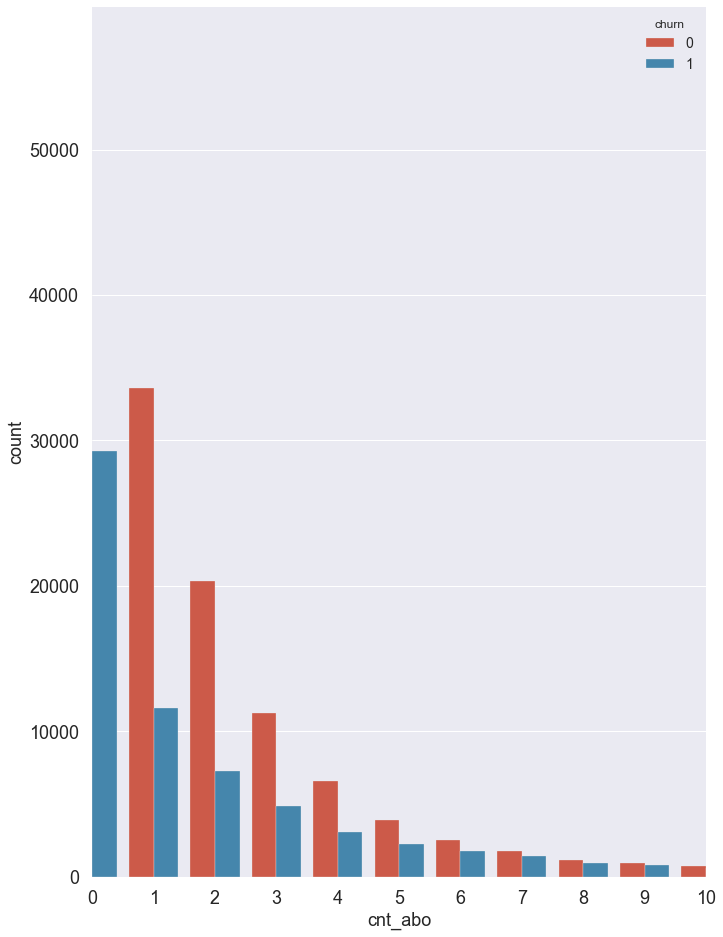

In [66]:
fig, ax = plt.subplots(figsize=(11,16))
ax = sns.countplot(x="cnt_abo", hue='churn',data=df)
#ax.set_xlim(0,10)

### objekt_name

In [ ]:
df.objekt_name.value_counts().plot(kind='bar',figsize=(11,6));

In [ ]:
objekt_churn = crosstab_evaluation(df.objekt_name,df.churn)
objekt_churn.sort_values(by=1,ascending=True,inplace=True)
crosstab_barplot(objekt_churn,['no churn','churn'],xlabelname='objekt name')

Combined subscription of Die Zeit with Christ & Welt has a remarkably smaller churn rate than Zeit Digital and Die Zeit print. 

In [ ]:
fig, ax = plt.subplots(figsize=(11,16))
ax = sns.countplot(x="objekt_name", hue='churn',data=df)

### aboform_name

In [ ]:
df.aboform_name.value_counts().plot(kind='bar',figsize=(11,6));

In [ ]:
aboform_churn = crosstab_evaluation(df.aboform_name,df.churn)
aboform_churn.sort_values(by=1,ascending=True,inplace=True)
crosstab_barplot(aboform_churn,['no churn','churn'],xlabelname='aboform')

Also here, we can see that Prämienabo has a much smaller churn rate than others, in particular Geschenkabo and Negative Option. 

### zahlung_rhythmus_name

In [ ]:
df.zahlung_rhythmus_name.value_counts().plot(kind='bar',figsize=(11,6));

In [ ]:
fig, ax = plt.subplots(figsize=(16,16))
ax = sns.countplot(x='zahlung_rhythmus_name',data=df,hue='churn')
ax.set_xlabel('');

In [ ]:
zahlung_rythmus_churn = crosstab_evaluation(df.zahlung_rhythmus_name,df.churn)
zahlung_rythmus_churn.sort_values(by=1,inplace=True,ascending=True)
crosstab_barplot(zahlung_rythmus_churn,['no churn','churn'],xlabelname='zahlung rythmus')

We can observe a strong dependence of the payment period on the churn rate. Payments with less than one year period tend to have higher churn rates.

### rechnungsmonat

In [ ]:
df.rechnungsmonat.value_counts().plot(kind='bar',figsize=(11,6));
plt.xlabel('rechnungsmonat');

Rechnungsmonat? What is the meaning?

In [ ]:
rechnungsmonat_churn = crosstab_evaluation(df.rechnungsmonat,df.churn)
crosstab_barplot(rechnungsmonat_churn,['no churn','churn'],xlabelname='rechnungsmonat')

If there is a billing months, a subscriber has a higher tendency to churn the subscription than without a billing month. 

### zahlung_weg_name

In [ ]:
df.zahlung_weg_name.value_counts().plot(kind='bar',figsize=(11,6));

In [ ]:
zahlungsweg_churn = crosstab_evaluation(df.zahlung_weg_name,df.churn)
crosstab_barplot(zahlungsweg_churn,['no churn','churn'],xlabelname='zahlungsweg')

If the payment is made by direct debit (Bankeinzug), the churn rate is much lower than if the payment is made by invoice. Credit Cards and Paypal are in between.

### studentenabo

In [ ]:
df.studentenabo.value_counts().plot(kind='bar',figsize=(11,6));

In [ ]:
studentenabo_churn = crosstab_evaluation(df.studentenabo,df.churn)
crosstab_barplot(studentenabo_churn,['no churn','churn'],xlabelname='studenten abo')
plt.ylabel('probability');

The students tend to churn more frequently.

#### Studentenmap

In [ ]:
plz3_students = crosstab_evaluation(df.plz_3,df.studentenabo)
#crosstab_barplot(plz3_students,['no student abo','student abo']ticklabelname='PLZ 3',figsize_x=50)

In [ ]:
def convert_plz_3_to_student(plz):
    index = str(plz)[0:3]
    #print(index)
    value = plz3_students[plz3_students.index == index].iloc[0,1]
    #print(value)
    return value

In [ ]:
germany_df['studenten_plz_3'] = germany_df.plz.apply(lambda x: convert_plz_3_to_student(x))

In [ ]:
fig, ax = plt.subplots(figsize=(11,16))

germany_df.plot(
    ax=ax, 
    column='studenten_plz_3', 
    categorical=False, 
    legend=True, 
    cmap='jet',
    alpha=0.8,

)

for c in top_cities.keys():

    ax.text(
        x=top_cities[c][0], 
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )

    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )
    
ax.set(
    title='Germany: Student Abo Rate of first three digit plz', 
    aspect=1.5, 
    facecolor='lightblue'
);
fig.savefig('plots/student_abo_rate.png',dpi=300)

Here we can see where the student churn rate is the highest and where it is the lowest.

### unterbrechung

In [ ]:
df.unterbrechung.value_counts().plot(kind='bar',figsize=(11,6));
plt.xlabel('unterbrechung');

In [ ]:
unterbrechung_churn = crosstab_evaluation(df.unterbrechung,df.churn)
crosstab_barplot(unterbrechung_churn,['no churn','churn'],xlabelname='unterbrechung')
plt.ylabel('probability');

The churn rate for interruptions of the subscription seems to be the same.  

### Summary Subscription Data

To sum up, the following was found about the subscription related features:

- **kanal:** An important feature for churn (20 to almost 40 percent churn rate for different channels: keep feature  
- **objekt_name:** Combined subscription have much less churn than digital and print subscriptions: keep feature  
- **aboform_name:** Churn rate is dependent on the form of subscription: keep feature 
- **zahlung_rhythmus_name:** Dependence of the payment period on the churn rate: keep feature
- **rechnungsmonat:** If there is a billing months, a subscriber has a higher tendency to churn: keep feature
- **zahlung_weg_name:** Direct debit (Bankeinzug) churn rate is much lower than if the payment is made by invoice: keep feature 
- **studentenabo:** Students tend to churn more frequently: keep feature
- **unterbrechung:** The churn rate for interruptions of the subscription seems to be the same: could be kept!

## Time/Temporal Features - Jonas

The following features are related to time subscription kind and shortly described: 
- lesedauer
- liefer_beginn_evt
- abo_registrierung_min
- nl_registrierung_min
- date_x
- kuendigungs_eingangs_datum


### lesedauer

In [ ]:
df.lesedauer.value_counts().sort_index().plot(kind='bar',figsize=(25,6));
#df.lesedauer.value_counts().sort_values('lesedauer').plot(kind='bar',figsize=(25,6));
plt.xlabel('lesedauer');

In [ ]:
lesedauer_churn = crosstab_evaluation(df.lesedauer,df.churn)
crosstab_barplot(lesedauer_churn,['no churn','churn'],xlabelname='lesedauer',figsize_x=25,figsize_y=10)
plt.ylabel('churn probability');
plt.xticks(np.arange(0, 88, 6.0),rotation=0);

The lesedauer is an important measure for the churn probability. With fewer months of lesedauer, the churn rate decreases, and then after 12 months there is a wave pattern with a period of 12 months (24, 36, 38, 60 months and so on) in which the churn rate increases.  )

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))
ax = sns.countplot(x='lesedauer',data=df,hue='churn')
ax.set_xlabel('');
plt.xticks(np.arange(0, 88, 6.0));
plt.xlabel('lesedauer');

### liefer_beginn_evt

In [ ]:
df.info()

In [ ]:
df.liefer_beginn_evt.isna().sum()

In [ ]:
# convert liefer beginn to datetime
df.liefer_beginn_evt.head()

In [ ]:
df['liefer_beginn_evt'] = pd.to_datetime(df['liefer_beginn_evt'])
#df['liefer_beginn_evt'] = df['liefer_beginn_evt'].dt.date
df.liefer_beginn_evt.describe()

In [ ]:
df.liefer_beginn_evt.hist(bins=100,figsize=(11,6));
plt.xlabel('Time');
plt.ylabel('Count');

In [ ]:
#plt.subplots(figsize=(15,6))
#ax = sns.countplot(x='liefer_beginn_evt', data=df)
#ax.set(xlabel='liefer_beginn_evt', ylabel='Frequency')
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### abo_registrierung_min

In [ ]:
df.abo_registrierung_min.isna().sum()

In [ ]:
# convert abo registrierung to datetime
df['abo_registrierung_min'] = pd.to_datetime(df['abo_registrierung_min'])
#df['abo_registrierung_min'] = df['abo_registrierung_min'].dt.date
df.abo_registrierung_min.describe()

In [ ]:
df.abo_registrierung_min.hist(bins=200,figsize=(11,6));
plt.xlabel('Time');
plt.ylabel('Count');

In [ ]:
df.abo_registrierung_min.hist(bins=200,figsize=(11,6));
plt.xlabel('Time');
plt.ylabel('Count');
plt.xlim('1960-01-01','2020-01-01');

### nl_registrierung_min

In [ ]:
df.nl_registrierung_min.isna().sum()

In [ ]:
# convert nl_registrierung to datetime
df['nl_registrierung_min'] = pd.to_datetime(df['nl_registrierung_min'], format='%Y-%m-%d')
#df['nl_registrierung_min'] = df['nl_registrierung_min'].dt.date
df.nl_registrierung_min.describe()

In [ ]:
df.info()

In [ ]:
df.nl_registrierung_min.head(2)

In [ ]:
df.nl_registrierung_min.hist(bins=200,figsize=(11,6));
plt.xlabel('Time');
plt.ylabel('Count');

In [ ]:
df.nl_registrierung_min.hist(bins=200,figsize=(11,6));
plt.xlabel('Time');
plt.ylabel('Count');
plt.xlim('2000-01-01','2020-01-01')

In [ ]:
#df['nl_registrierung_min'] = [time.date() for time in df['nl_registrierung_min']]

In [ ]:
df.nl_registrierung_min.head(2)

### date_x

In [ ]:
df.date_x.isna().sum()

In [ ]:
# convert date_x to datetime
df['date_x'] = pd.to_datetime(df['date_x'], format='%Y-%m-%d')
df['date_x'] = df['date_x'].dt.date
df.date_x.describe()

In [ ]:
df.date_x.head(2)

In [ ]:
df.date_x.hist(bins=100,figsize=(11,6));
plt.xlabel('Time');
plt.ylabel('Count');

### kuendigungs_eingangs_datum

In [ ]:
df.kuendigungs_eingangs_datum.isna().sum()

In [ ]:
df.kuendigungs_eingangs_datum.fillna(value='1900-01-01 00:00:00',inplace=True);

In [ ]:
# convert date_x to datetime
df['kuendigungs_eingangs_datum'] = pd.to_datetime(df['kuendigungs_eingangs_datum'],errors='coerce',format='%Y-%m-%d')
#df['kuendigungs_eingangs_datum'] = df['kuendigungs_eingangs_datum'].dt.date
df.kuendigungs_eingangs_datum.describe()

In [ ]:
df.info()

In [ ]:
df.kuendigungs_eingangs_datum.hist(bins=200,figsize=(11,6));
plt.xlabel('Time');
plt.ylabel('Count');

In [ ]:
df.kuendigungs_eingangs_datum.hist(bins=1000,figsize=(11,6));
plt.xlabel('Time');
plt.ylabel('Count');
plt.xlim('2019-01-01','2020-06-01');
#plt.ylim(0,10000)

#### Kündigungen 2020

In [ ]:
kuendigungen_2020 = df[df['kuendigungs_eingangs_datum'] > '2020-01-01']
kuendigungen_2020.shape

In [ ]:
df['kuendigungs_eingangs_datum'][0]

In [ ]:
kuendigungen_2020.kuendigungs_eingangs_datum.max()

In [ ]:
kuendigungen_2020.kuendigungs_eingangs_datum.head()

In [ ]:
kuendigungen_2020 = kuendigungen_2020.sort_values(by="kuendigungs_eingangs_datum",ascending=True)

In [ ]:
kuendigungen_2020.head(2)

In [ ]:
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.dates import DateFormatter, MonthLocator, YearLocator

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots(figsize=(18,8))

sns.countplot(kuendigungen_2020['kuendigungs_eingangs_datum']);
plt.xticks(rotation=90);
plt.xlabel('kuendigungs_eingang_datum 2020')

months = MonthLocator()
monthsFmt = DateFormatter("%b")

years = YearLocator()
yearsFmt = DateFormatter("%y")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

#ax.xaxis.set_major_locator(months)
#ax.xaxis.set_major_formatter(monthsFmt)

#### Kündigungen 2019

In [ ]:
kuendigungen_2019 = df[(df['kuendigungs_eingangs_datum'] < '2020-01-01') & (df['kuendigungs_eingangs_datum'] > '2019-01-01')]
kuendigungen_2019.shape

In [ ]:
kuendigungen_2019.kuendigungs_eingangs_datum.min()

In [ ]:
kuendigungen_2019.kuendigungs_eingangs_datum.head()

In [ ]:
kuendigungen_2019 = kuendigungen_2019.sort_values(by="kuendigungs_eingangs_datum",ascending=True)

In [ ]:
kuendigungen_2019.head(2)

In [ ]:
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.dates import DateFormatter, MonthLocator, YearLocator

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots(figsize=(18,8))

ax = sns.countplot(kuendigungen_2019['kuendigungs_eingangs_datum']);
plt.xticks(rotation=90);
plt.xlabel('kuendigungs_eingang_datum 2019')

months = MonthLocator()
monthsFmt = DateFormatter("%m-%d")

years = YearLocator()
yearsFmt = DateFormatter("%y")

#ax.xaxis.set_major_formatter(monthsFmt)
#ax.xaxis.set_major_locator(months)

date_form = DateFormatter("%m-%d")
#ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

#ax.set_xlim(pd.datetime.strptime(startDate,'%Y-%m-%d'),pd.datetime.strptime(stopDate,'%Y-%m-%d'))

### Time relation between kuendigungs_eingangs_datum und lieferstart

In [ ]:
df_churn = df.query('churn == 1')

In [ ]:
df_churn['delivery_to_churn'] = df_churn['kuendigungs_eingangs_datum'] - df_churn['liefer_beginn_evt']

In [ ]:
df_churn.head(2)

In [ ]:
df_churn['delivery_to_churn'].astype('timedelta64[s]').div(2592000).plot.hist(bins=120,figsize=(20,6));
plt.xlabel('months from delivery to churn receiving');
plt.xticks(np.arange(0,120,12));

In [ ]:
df_churn['delivery_to_churn'].astype('timedelta64[s]').div(2592000).max()

In [ ]:
df_churn['delivery_to_churn'] = df_churn['delivery_to_churn'].astype('timedelta64[s]').div(2592000)

In [ ]:
df_churn['delivery_to_churn'].head(2)

In [ ]:
months_bins = np.arange(0, 90.5, 0.5)
months_bins

In [ ]:
months_bin_series = pd.cut(df_churn['delivery_to_churn'], bins=months_bins, labels=months_bins[:-1])
months_bin_series.name = 'months_bins_2m'
df_churn['months_bins_2m'] = months_bin_series

In [ ]:
df_churn.head(2)

In [ ]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots(figsize=(11,16))
df_churn.groupby('months_bins_2m').count()['churn'].plot(kind='bar',figsize=(20,6))
x_ticks = np.arange(0, 120, 2);
plt.xticks(x_ticks);
plt.xlim(0,98);
plt.ylabel('Number of churns');
plt.xlabel('Months from delivery to date of receipt of the churn');

#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))

### Time Relation between kuendigungs_eingangs_datum and nl_registrierung_min

In [ ]:
df_churn['nl_start_to_churn'] = df_churn['kuendigungs_eingangs_datum'] - df_churn['nl_registrierung_min']

In [ ]:
df_churn.head(2)

In [ ]:
df_churn['nl_start_to_churn'].astype('timedelta64[s]').div(2592000).plot.hist(bins=1200,figsize=(20,6));
plt.xlabel('months from nl_registrierung min to churn receiving');
plt.xlim(-10,200);

In [ ]:
df_churn['nl_start_to_churn'] = df_churn['nl_start_to_churn'].astype('timedelta64[s]').div(2592000)

In [ ]:
df_churn['nl_start_to_churn'].head(2)

In [ ]:
months_bins = np.arange(0, 90.5, 0.5)
months_bins

In [ ]:
nl_min_bins_series = pd.cut(df_churn['nl_start_to_churn'], bins=months_bins, labels=months_bins[:-1])
nl_min_bins_series.name = 'nl_min_bins_05m'
df_churn['nl_start_to_churn_bins_05m'] = nl_min_bins_series

In [ ]:
fig, ax = plt.subplots(figsize=(11,16))
df_churn.groupby('nl_start_to_churn_bins_05m').count()['churn'].plot(kind='bar',figsize=(20,6))
x_ticks = np.arange(0, 120, 2);
plt.xticks(x_ticks);
plt.xlim(0,98);
plt.ylabel('Number of churns');
plt.xlabel('Months from nl_registrierung_min to date of receipt of the churn');

## Activity features

These features were we can see interactions and communicate with the customers.

- newsletter
- clickrates
- openrates
- community

In [19]:
index=0
for elem in df.columns:   
    print(f"{index} {elem}")
    index+=1

0 liefer_beginn_evt
1 kanal
2 objekt_name
3 aboform_name
4 zahlung_rhythmus_name
5 lesedauer
6 rechnungsmonat
7 zahlung_weg_name
8 studentenabo
9 plz_1
10 plz_2
11 plz_3
12 ort
13 metropole
14 land_iso_code
15 shop_kauf
16 unterbrechung
17 anrede
18 titel
19 avg_churn
20 email_am_kunden
21 zon_che_opt_in
22 zon_sit_opt_in
23 zon_zp_grey
24 zon_premium
25 zon_boa
26 zon_kommentar
27 zon_sonstige
28 zon_zp_red
29 zon_rawr
30 zon_community
31 zon_app_sonstige
32 zon_schach
33 zon_blog_kommentare
34 zon_quiz
35 cnt_abo
36 cnt_abo_diezeit
37 cnt_abo_diezeit_digital
38 cnt_abo_magazin
39 cnt_umwandlungsstatus2_dkey
40 abo_registrierung_min
41 nl_zeitbrief
42 nl_zeitshop
43 nl_zeitverlag_hamburg
44 nl_fdz_organisch
45 nl_blacklist_sum
46 nl_bounced_sum
47 nl_aktivitaet
48 nl_registrierung_min
49 nl_sperrliste_sum
50 nl_opt_in_sum
51 boa_reg
52 che_reg
53 sit_reg
54 sso_reg
55 received_anzahl_1w
56 received_anzahl_1m
57 received_anzahl_3m
58 received_anzahl_6m
59 opened_anzahl_1w
60 opened_anz

Create dataframes for differen activity features:

In [20]:
df_zon = df.iloc[::, 21:35]                # zones are special areas that need registration
df_cnt = df.iloc[::, 35:40]                # cnt is the number of subscribtions the contract holds (families, libaries etc.)
df_nl = df.iloc[::, 41:51]                 # newsletter drop technical details
df_nl.drop(["nl_blacklist_sum", "nl_bounced_sum", "nl_sperrliste_sum", "nl_opt_in_sum", "nl_fdz_organisch", "nl_registrierung_min"], axis=1, inplace=True)
df_reg = df.iloc[::, 51:55]                # registration needed (for accses to these services)
df_nl_interact = df.iloc[::, 55:77]        # newsletter interactions
df_nl_bestandskunden = df.iloc[::, 77:99]  # newsletter existing customers
df_nl_produktnews = df.iloc[::, 99:121]    # productnews (kind of newsletter but more commercial)
df_nl_hamburg = df.iloc[::, 121:143]       # newsletter region hamburg
df_zb = df.iloc[::, 143:165]               # zb = zeitbrief kind of letter

### Customer Email
The feature email_am_kunden is a feature which shows if the email of an subscriber is known to the publisher.
* 0:not known
* 1:known

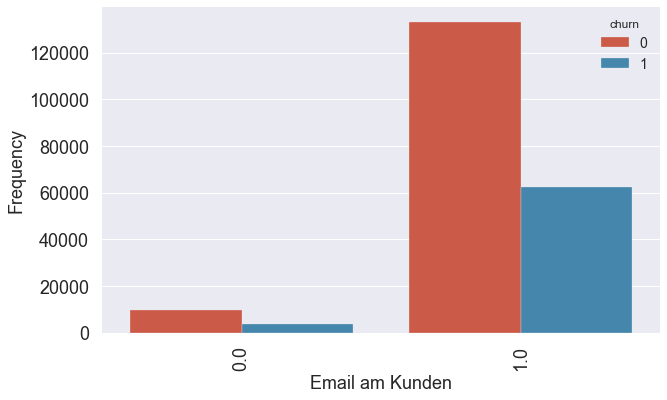

In [21]:
plt.subplots(figsize=(10,6))
ax = sns.countplot(x='email_am_kunden', hue='churn', data=df)
ax.set(xlabel='Email am Kunden', ylabel='Frequency')
ax.set(ylim=(0, None))


ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

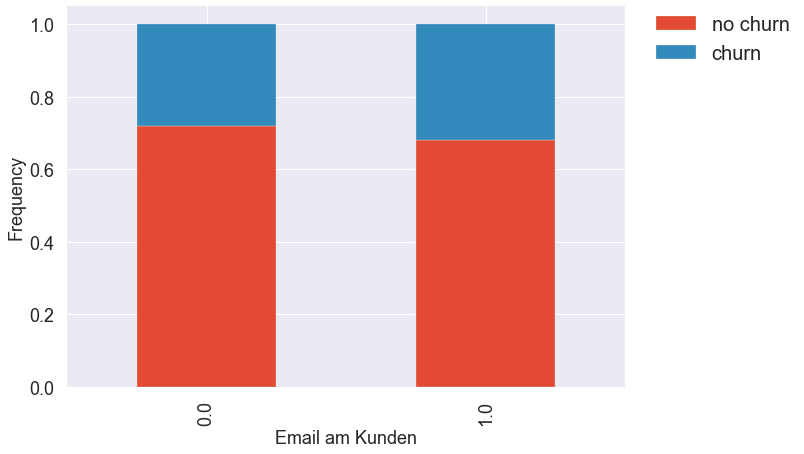

In [22]:
email_am_kunden_churn = crosstab_evaluation(df.email_am_kunden,df.churn)
crosstab_barplot(email_am_kunden_churn,['no churn','churn'],xlabelname='Email am Kunden')

In [23]:
df['email_am_kunden'].value_counts()/df.shape[0]

1.0    0.935666
0.0    0.064334
Name: email_am_kunden, dtype: float64

__Observations:__ 
* Only 6.4% of the mail adresses of all subscribers are unknown
* The relative churn rate is a little bit higher for subscibers with known email adresses, but not a big difference is visible

### Newsletter features

,received_anzahl_1w,received_anzahl_1m,received_anzahl_3m,received_anzahl_6m,opened_anzahl_1w,opened_anzahl_1m,opened_anzahl_3m,openedanzahl_6m,clicked_anzahl_1w,clicked_anzahl_1m,clicked_anzahl_3m,clicked_anzahl_6m,unsubscribed_anzahl_1w,unsubscribed_anzahl_1m,unsubscribed_anzahl_3m,unsubscribed_anzahl_6m,openrate_1w,clickrate_1w,openrate_1m,clickrate_1m,openrate_3m,clickrate_3m
received_anzahl_1w,1.00,0.98,0.96,0.94,0.60,0.63,0.61,0.60,0.26,0.36,0.35,0.33,-0.01,-0.01,-0.02,-0.04,0.17,0.11,0.18,0.10,0.15,0.07
received_anzahl_1m,0.98,1.00,0.98,0.97,0.59,0.64,0.63,0.62,0.25,0.36,0.36,0.34,0.01,0.01,-0.01,-0.04,0.18,0.10,0.19,0.10,0.15,0.07
received_anzahl_3m,0.96,0.98,1.00,0.99,0.58,0.64,0.64,0.64,0.24,0.35,0.36,0.35,0.02,0.02,0.01,-0.02,0.18,0.10,0.19,0.10,0.15,0.07
received_anzahl_6m,0.94,0.97,0.99,1.00,0.57,0.62,0.63,0.64,0.23,0.35,0.35,0.34,0.03,0.03,0.03,0.01,0.18,0.10,0.18,0.10,0.15,0.07
opened_anzahl_1w,0.60,0.59,0.58,0.57,1.00,0.92,0.89,0.87,0.42,0.50,0.49,0.47,0.02,0.02,0.01,0.01,0.61,0.14,0.55,0.08,0.50,0.02
opened_anzahl_1m,0.63,0.64,0.64,0.62,0.92,1.00,0.97,0.94,0.38,0.54,0.52,0.50,0.03,0.03,0.02,0.01,0.50,0.12,0.59,0.08,0.53,0.01
opened_anzahl_3m,0.61,0.63,0.64,0.63,0.89,0.97,1.00,0.99,0.36,0.52,0.53,0.51,0.03,0.03,0.03,0.02,0.48,0.11,0.57,0.07,0.56,0.01
openedanzahl_6m,0.60,0.62,0.64,0.64,0.87,0.94,0.99,1.00,0.36,0.50,0.52,0.52,0.03,0.03,0.04,0.04,0.47,0.11,0.56,0.07,0.55,0.01
clicked_anzahl_1w,0.26,0.25,0.24,0.23,0.42,0.38,0.36,0.36,1.00,0.76,0.72,0.70,0.06,0.06,0.04,0.03,0.28,0.67,0.26,0.38,0.24,0.26
clicked_anzahl_1m,0.36,0.36,0.35,0.35,0.50,0.54,0.52,0.50,0.76,1.00,0.91,0.85,0.05,0.05,0.03,0.03,0.26,0.41,0.31,0.44,0.28,0.29


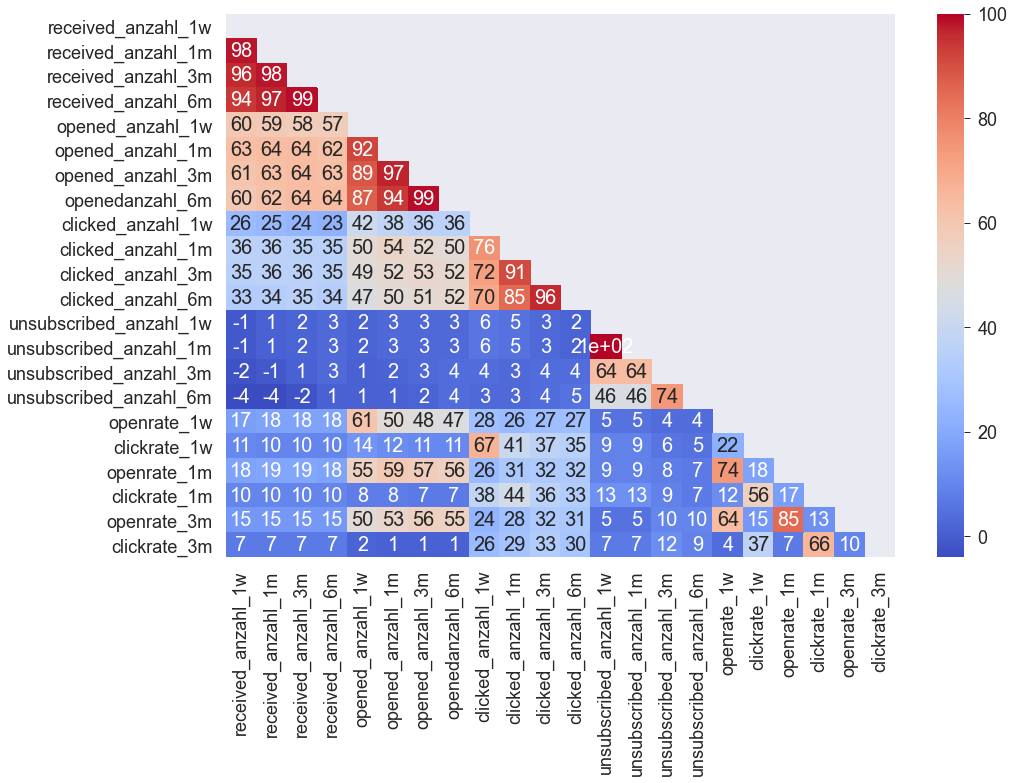

In [24]:
eda.correlogram(df_nl_interact)

**Observations:**

- df_nl the holds the four feature "nl_zeitbrief", "nl_zeitshop", "nl_zeitvrlag_hamburg" and "nl_aktivitaet". The only correlation is between "nl_aktivitaet" and "nl_zeitbrief". Altought this is not surprising, cause the feature "nl_aktivitaet" is an aggregation of user activity on the newsletters.

- The restrictad hp areas (registration needed) show correlations between each other between 15 and 27.

- The dataframe df_nl_interact contains all newsletter features. They are contain information aggregated for 1w, 1m, 3m and 6m. They are highly correlated because they contain from themselves. If there is a newsletter last week it is counted in every feature. Next to the timestamp (1w, 1m, 3m and 6m) the features in this df are devided by kind of interaction. These are recived, opened, clicked, unsubscribed, openrate and clickrate. 

- df_nl_bestandskunden, df_nl_produktnews, df_nl_hamburg and df_zb show the same puicture as df_nl_interact.

- The correlogram(df_zon) showed no mentionable correlations (rounded values -1 or 0).
- When we had a look at the correlogram(df_cnt) there were strong correlation. This is surprising cause the cnt_abo features are these that count the sum of abos a customers keeps. For example if one person has more than one newspaper, or a newspaper and a magazin, or newspaper print and digital. For more information about the subscription types check the [wiki: Business understanding](https://github.com/jb-ds2020/nf-ds3-capstone-churn-prevention/wiki/Business-understanding-(publishing-and-news)).


### Shop Kauf

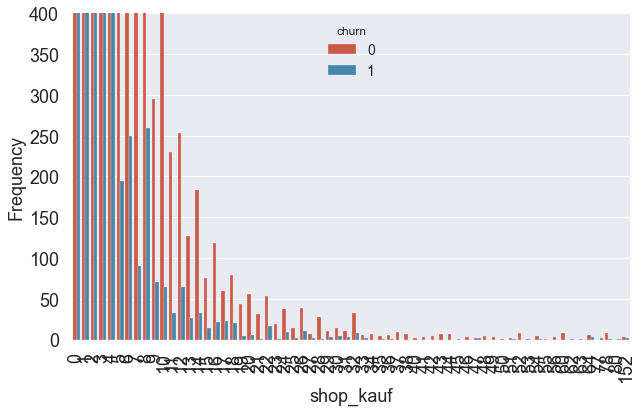

In [27]:
plt.subplots(figsize=(10,6))
ax = sns.countplot(x='shop_kauf', hue='churn', data=df)
ax.set(xlabel='shop_kauf', ylabel='Frequency')
ax.set(ylim=(0, 400))


ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

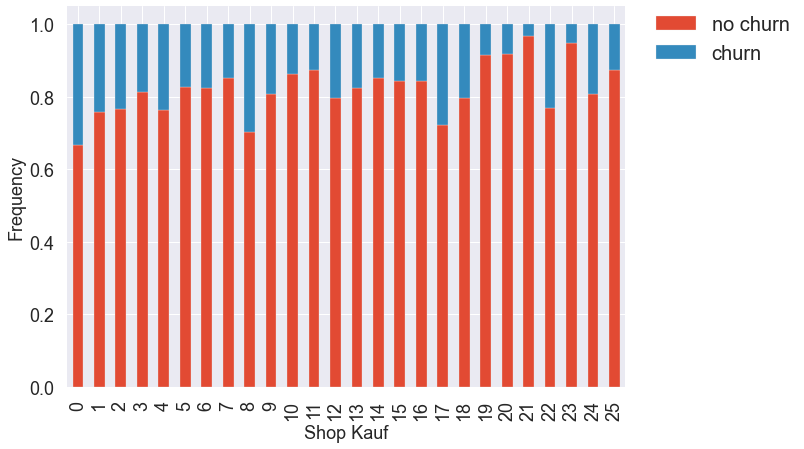

In [56]:
shop_churn = crosstab_evaluation(df.shop_kauf,df.churn)
crosstab_barplot(shop_churn,['no churn','churn'],xlabelname='Shop Kauf')
plt.xlim(-0.5,25.5);

### Newsletter
__Email-Newsletter:__ <br>
with: 0:not available, 1: unsubscribed, 2: active
* nl_zeitbrief 
* nl_zeitshop
* nl_zeitverlag_hamburg
* nl_fdz_organisch: on organic recipient list Loyaltyprogram fdZ
</p>
* Blacklist: Number of blacklist entries
* Bounced: Number of Bounces
* Aktivität: Number on how many newsletters in the house
* Sperrliste
</p>
* nl_opt_in_sum: Number of Optins

In [ ]:
for i in ['nl_zeitbrief', 'nl_zeitshop', 'nl_zeitverlag_hamburg', 'nl_fdz_organisch']:
    
    
    plt.subplots(figsize=(10,6))
    ax = sns.countplot(x=i, hue='churn', data=df)
    ax.set(xlabel=i, ylabel='Frequency')

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [ ]:
for i in ['nl_zeitbrief', 'nl_zeitshop', 'nl_zeitverlag_hamburg', 'nl_fdz_organisch']:
    x = crosstab_evaluation(df[i],df.churn)
    crosstab_barplot(x,['no churn','churn'],xlabelname=i)

__Absolute Blacklist and Bounced__

In [ ]:
for i in ['nl_blacklist_sum', 'nl_bounced_sum']:
    
    
    plt.subplots(figsize=(10,6))
    ax = sns.countplot(x=i, hue='churn', data=df)
    ax.set(xlabel=i, ylabel='Frequency')

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

__Relative Blacklist and Bounced__

In [ ]:
for i in ['nl_blacklist_sum', 'nl_bounced_sum']:
    x = crosstab_evaluation(df[i],df.churn)
    crosstab_barplot(x,['no churn','churn'],xlabelname=i)

__Absolute NL Aktivitaet and Sperrliste__

In [ ]:
for i in ['nl_aktivitaet', 'nl_sperrliste_sum']:
    
    
    plt.subplots(figsize=(10,6))
    ax = sns.countplot(x=i, hue='churn', data=df)
    ax.set(xlabel=i, ylabel='Frequency', xlim=[0,None])

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90) 

__Relative NL Aktivität and Sperrliste__

In [ ]:
for i in ['nl_aktivitaet', 'nl_sperrliste_sum']:
    x = crosstab_evaluation(df[i],df.churn)
    crosstab_barplot(x,['no churn','churn'],xlabelname=i)

__Absolute NL Optins__

In [ ]:
plt.subplots(figsize=(10,6))
ax = sns.countplot(x=df['nl_opt_in_sum'], hue='churn', data=df)
ax.set(xlabel='NL Optins', ylabel='Frequency', xlim=[0,None])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90); 

__Relative NL Optins__

In [ ]:
x = crosstab_evaluation(df['nl_opt_in_sum'],df.churn)
crosstab_barplot(x,['no churn','churn'],xlabelname='NL Optins')

#### Bestandskunden
* with received, opened, clicked, unsubscribed mails
* time period = 6m 

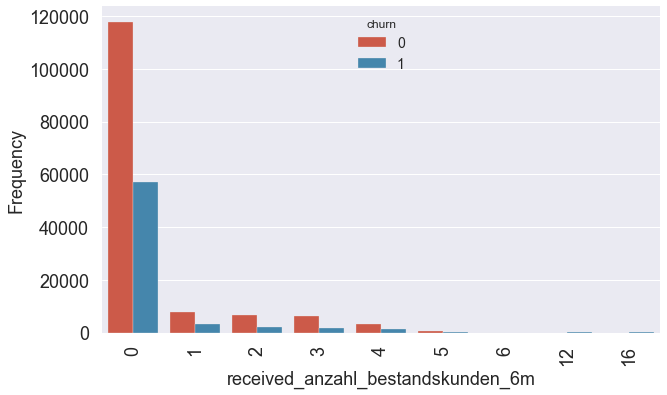

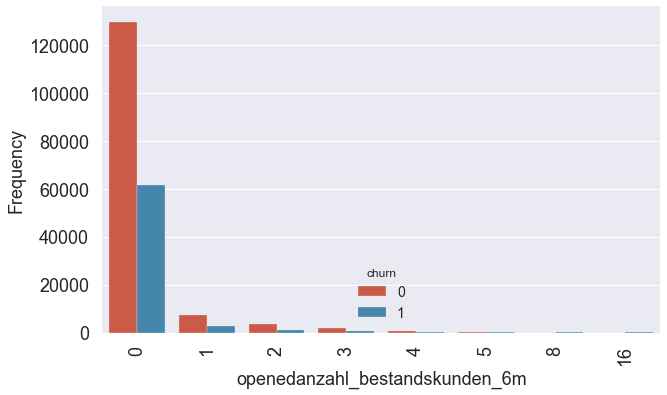

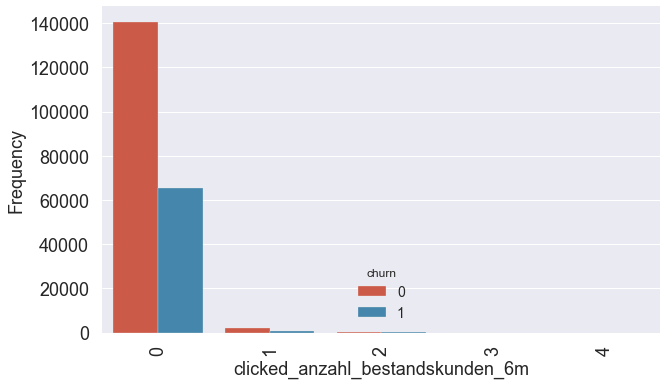

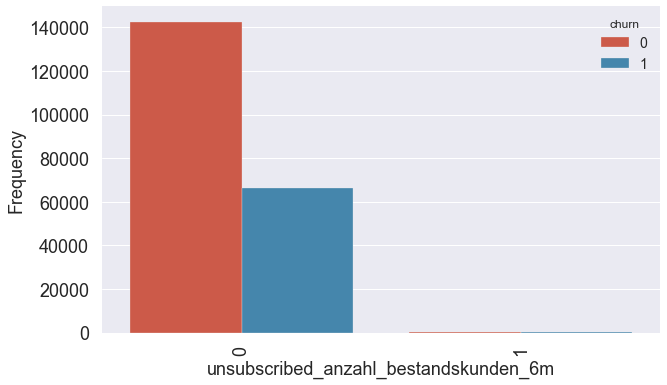

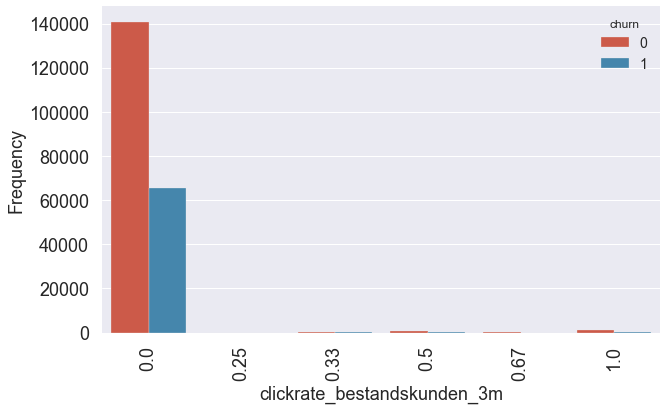

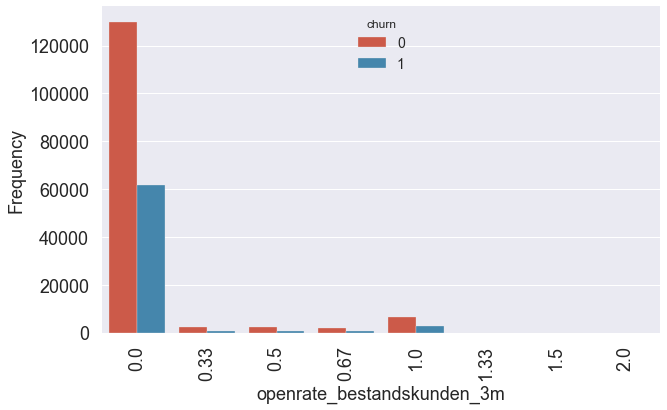

In [33]:
for i in ['received_anzahl_bestandskunden_6m', 'openedanzahl_bestandskunden_6m', 'clicked_anzahl_bestandskunden_6m', 'unsubscribed_anzahl_bestandskunden_6m', 'clickrate_bestandskunden_3m', 'openrate_bestandskunden_3m']:
    
    
    plt.subplots(figsize=(10,6))
    ax = sns.countplot(x=i, hue='churn', data=df)
    ax.set(xlabel=i, ylabel='Frequency')

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

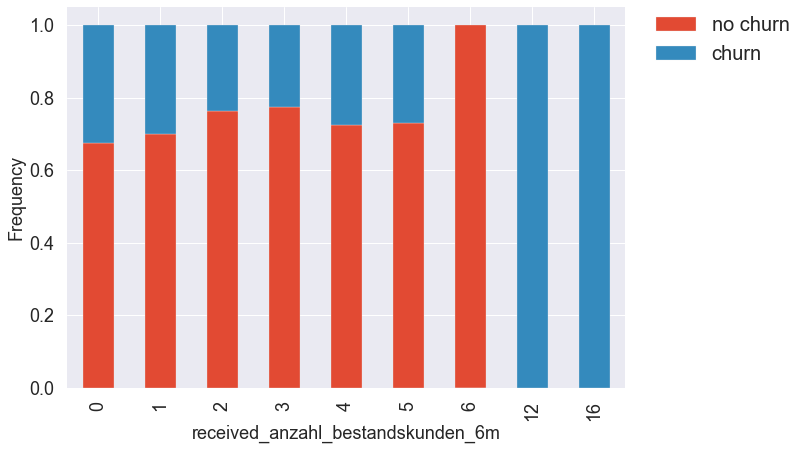

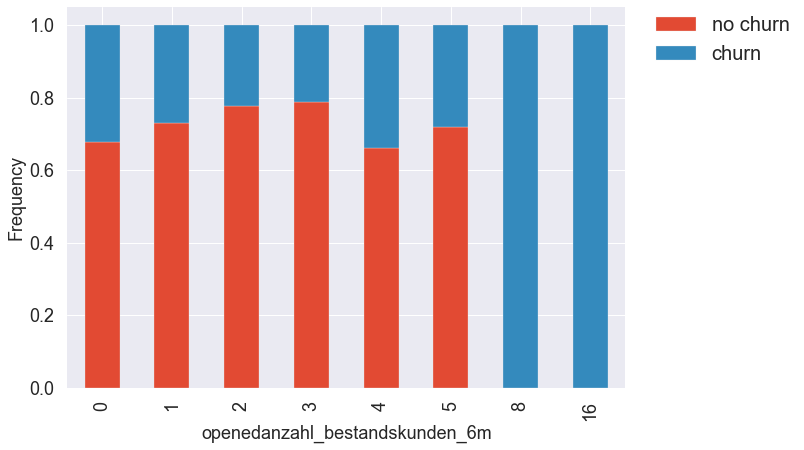

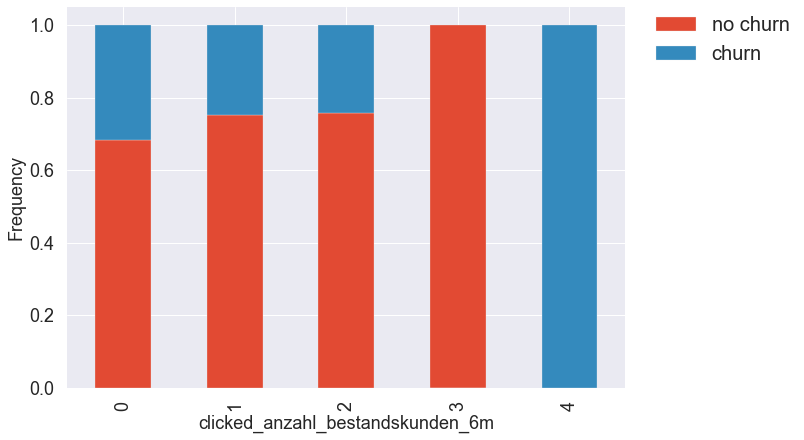

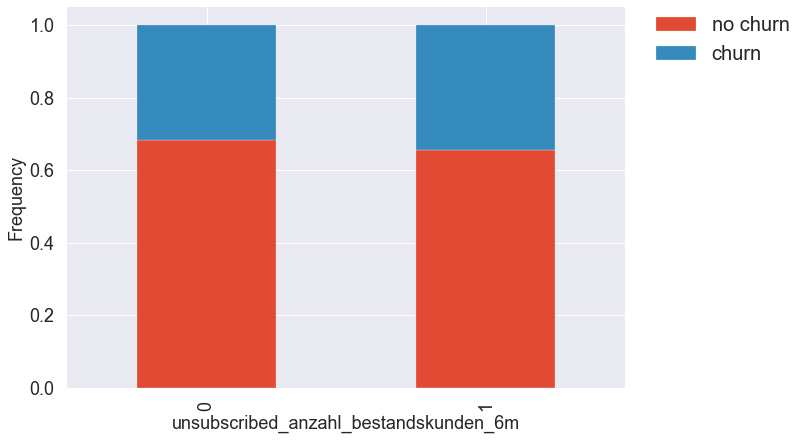

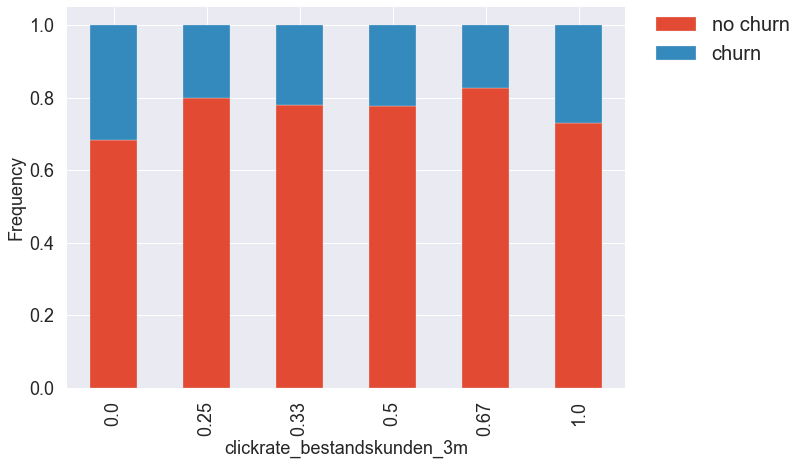

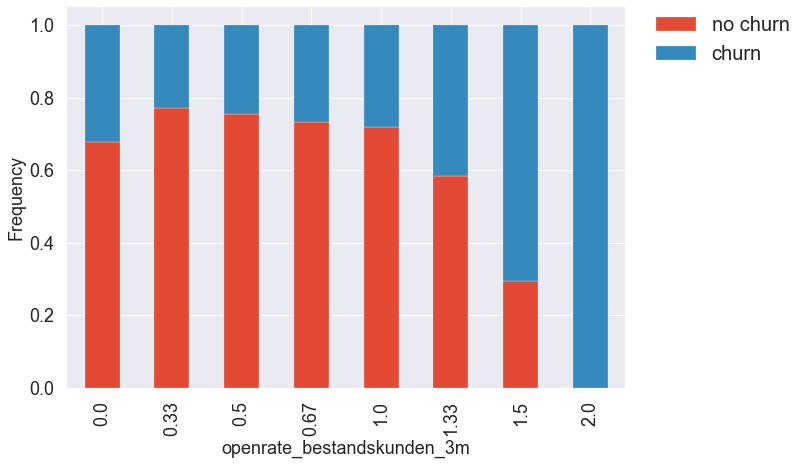

In [34]:
for i in ['received_anzahl_bestandskunden_6m', 'openedanzahl_bestandskunden_6m', 'clicked_anzahl_bestandskunden_6m', 'unsubscribed_anzahl_bestandskunden_6m', 'clickrate_bestandskunden_3m', 'openrate_bestandskunden_3m']:
    
    x = crosstab_evaluation(df[i],df.churn)
    crosstab_barplot(x,['no churn','churn'],xlabelname=i)
   

#### Produktnews
* with received, opened, clicked, unsubscribed mails
* time period = 6m 

In [ ]:
for i in ['received_anzahl_produktnews_6m', 'openedanzahl_produktnews_6m', 'clicked_anzahl_produktnews_6m', 'unsubscribed_anzahl_produktnews_6m', 'clickrate_produktnews_3m', 'openrate_produktnews_3m']:
    
    
    plt.subplots(figsize=(10,6))
    ax = sns.countplot(x=i, hue='churn', data=df)
    ax.set(xlabel=i, ylabel='Frequency')

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [ ]:
for i in ['received_anzahl_produktnews_6m', 'openedanzahl_produktnews_6m', 'clicked_anzahl_produktnews_6m', 'unsubscribed_anzahl_produktnews_6m', 'clickrate_produktnews_3m', 'openrate_produktnews_3m']:
    x = crosstab_evaluation(df[i],df.churn)
    crosstab_barplot(x,['no churn','churn'],xlabelname=i)

#### Hamburg
Daily Newsletter (Mo-Fr)
* with received, opened, clicked, unsubscribed mails
* time period = 6m 

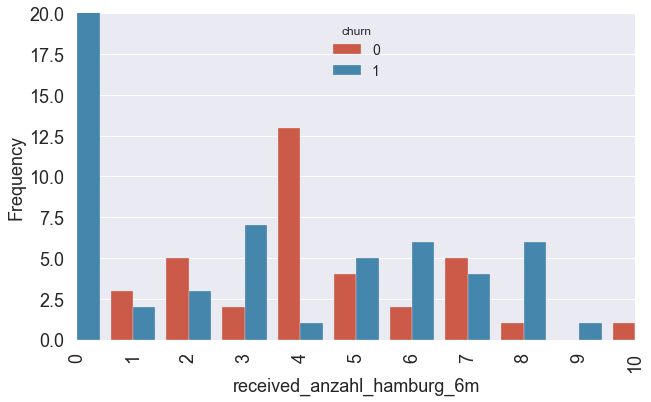

In [35]:
plt.subplots(figsize=(10,6))
ax = sns.countplot(x='received_anzahl_hamburg_6m', hue='churn', data=df)
ax.set(xlabel='received_anzahl_hamburg_6m', ylabel='Frequency')
ax.set(ylim=(0, 20))
ax.set(xlim=(0, 10))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

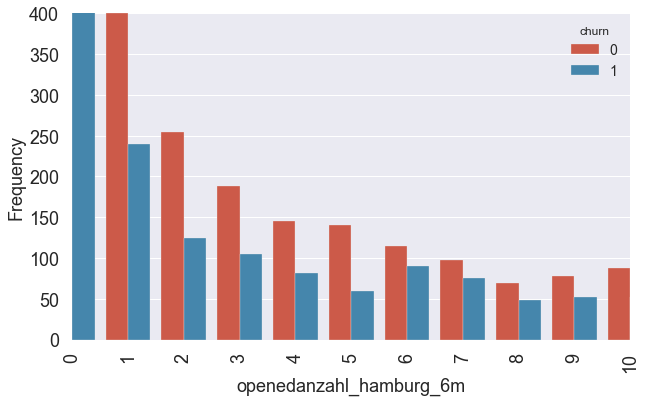

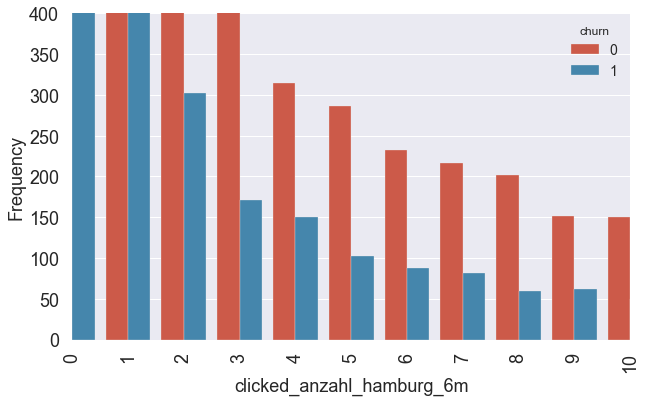

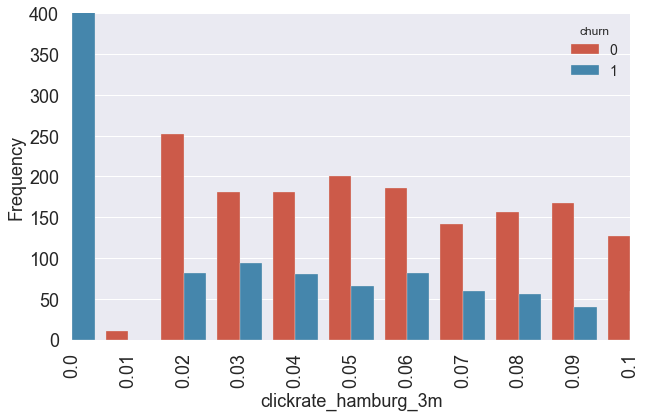

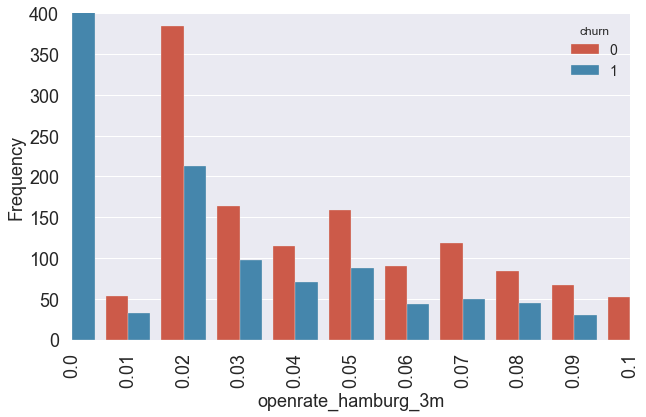

In [36]:
for i in ['openedanzahl_hamburg_6m', 'clicked_anzahl_hamburg_6m', 'clickrate_hamburg_3m', 'openrate_hamburg_3m']:
    
    
    plt.subplots(figsize=(10,6))
    ax = sns.countplot(x=i, hue='churn', data=df)
    ax.set(xlabel=i, ylabel='Frequency')
    ax.set(ylim=(0, 400))
    ax.set(xlim=(0, 10))

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

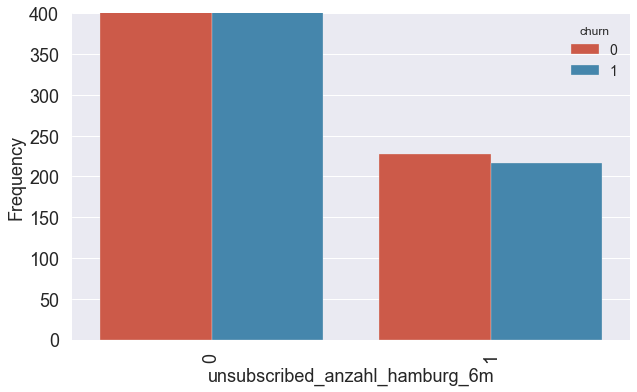

In [37]:
plt.subplots(figsize=(10,6))
ax = sns.countplot(x='unsubscribed_anzahl_hamburg_6m', hue='churn', data=df)
ax.set(xlabel='unsubscribed_anzahl_hamburg_6m', ylabel='Frequency')
ax.set(ylim=(0, 400))


ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

In [ ]:
for i in ['received_anzahl_hamburg_6m', 'openedanzahl_hamburg_6m', 'clicked_anzahl_hamburg_6m', 'unsubscribed_anzahl_hamburg_6m', 'clickrate_hamburg_3m', 'openrate_hamburg_3m']:
    x = crosstab_evaluation(df[i],df.churn)
    crosstab_barplot(x,['no churn','churn'],xlabelname=i, figsize_x=25)

#### Zeitbrief
* with received, opened, clicked, unsubscribed mails
* time period = 6m  

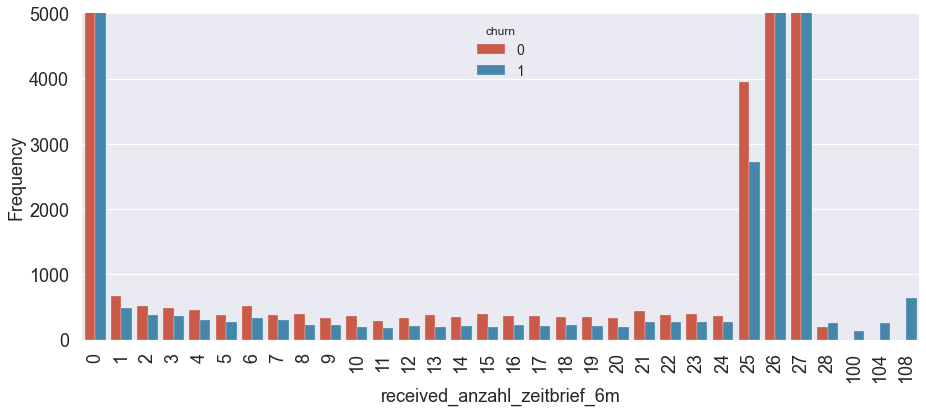

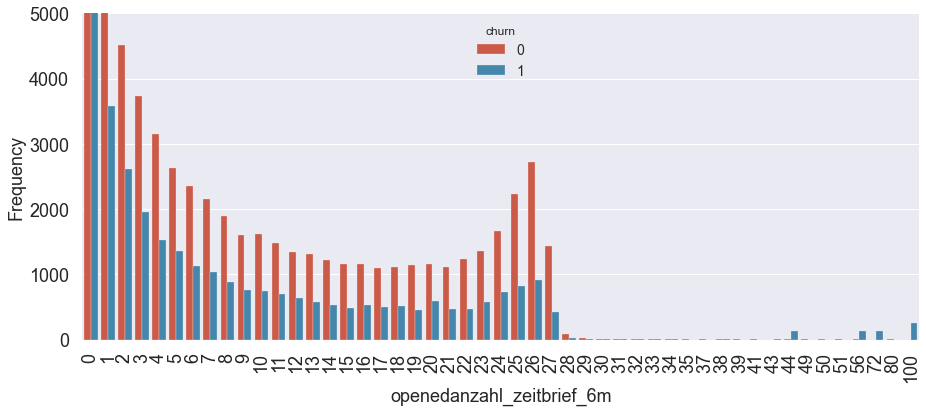

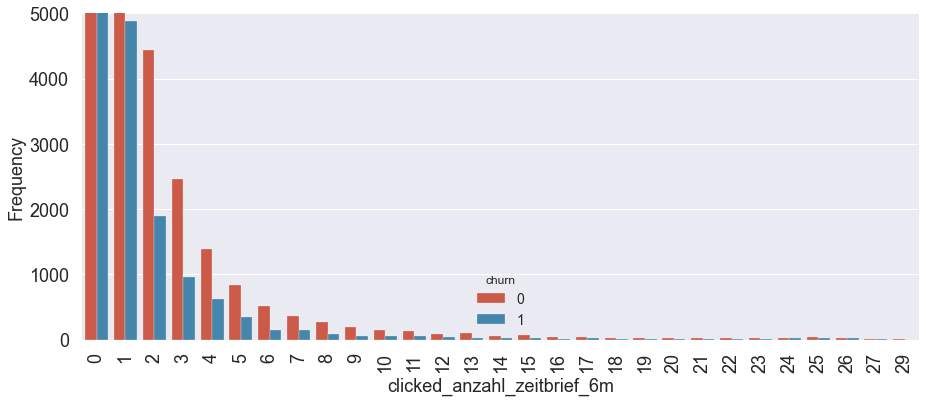

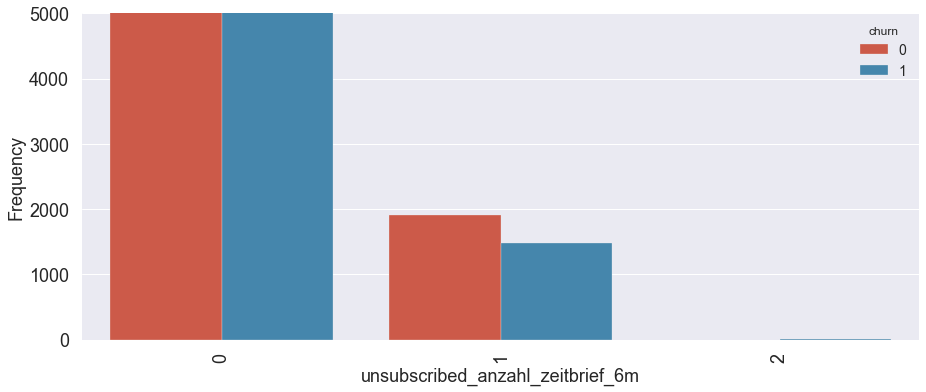

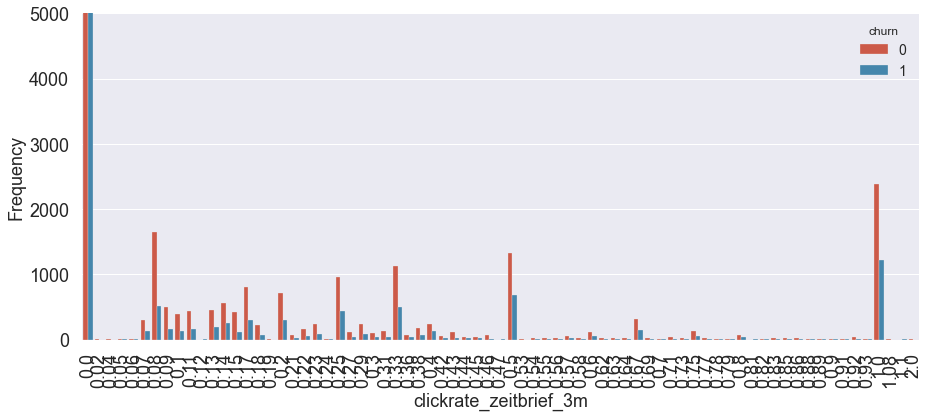

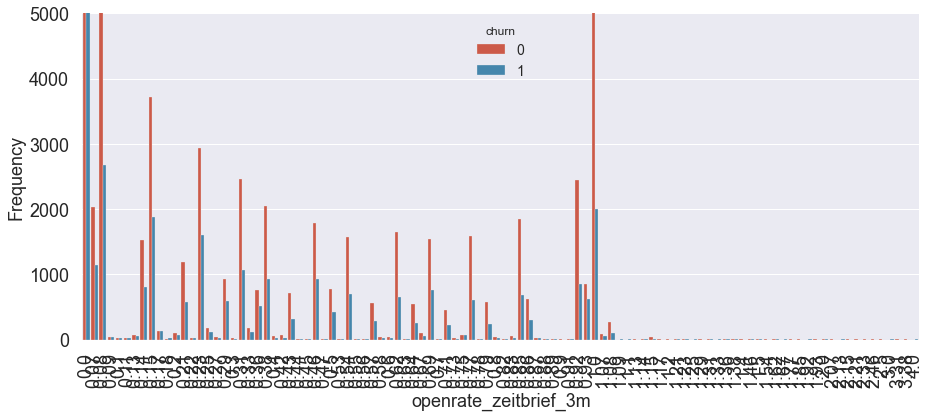

In [38]:
for i in ['received_anzahl_zeitbrief_6m', 'openedanzahl_zeitbrief_6m', 'clicked_anzahl_zeitbrief_6m', 'unsubscribed_anzahl_zeitbrief_6m', 'clickrate_zeitbrief_3m', 'openrate_zeitbrief_3m']:
    
    
    plt.subplots(figsize=(15,6))
    ax = sns.countplot(x=i, hue='churn', data=df)
    ax.set(xlabel=i, ylabel='Frequency')
    ax.set(ylim=(0, 5000))

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

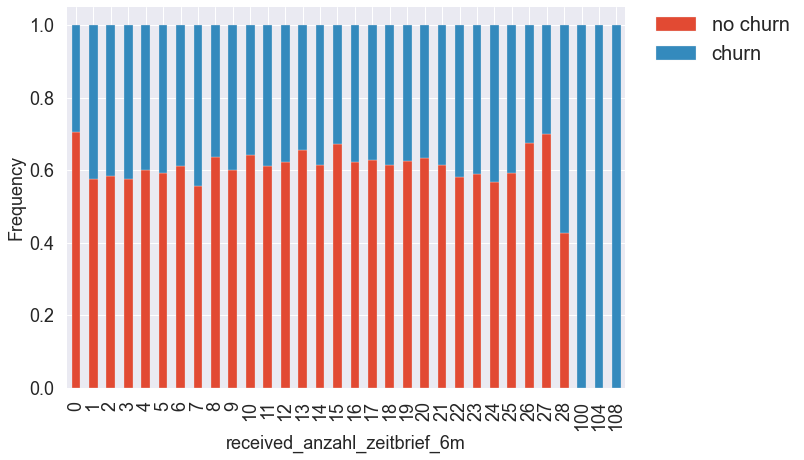

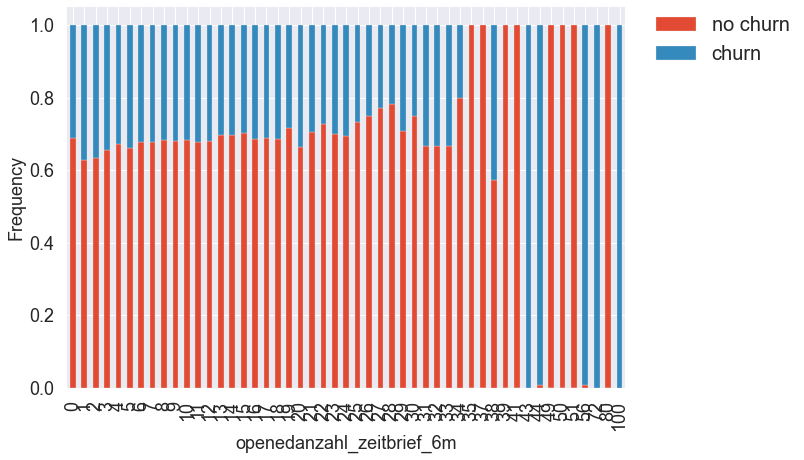

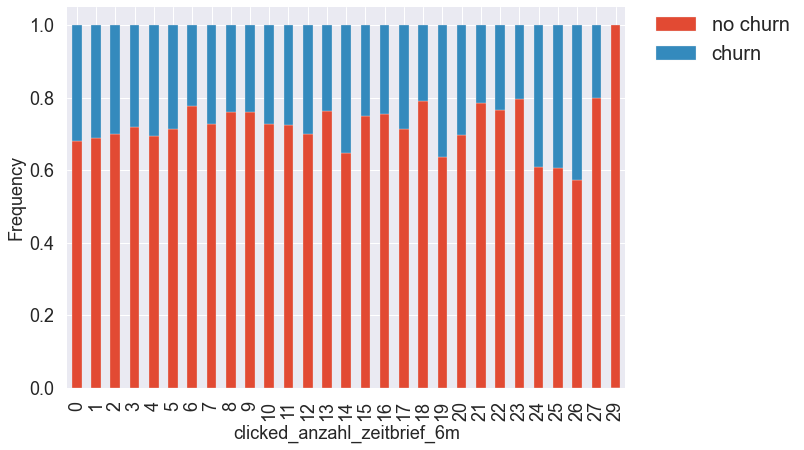

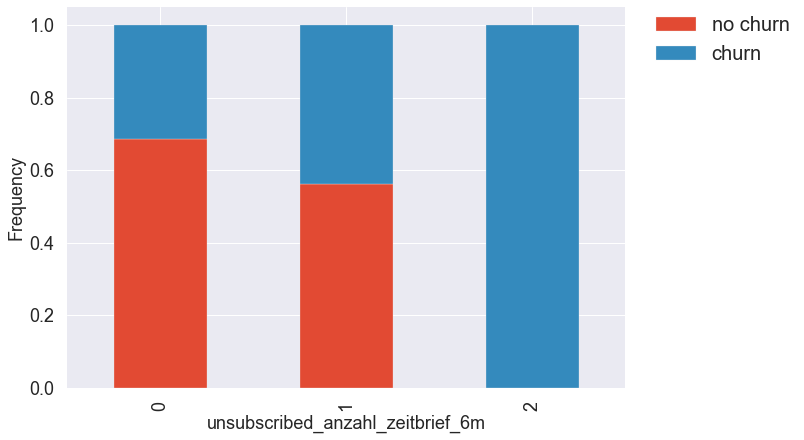

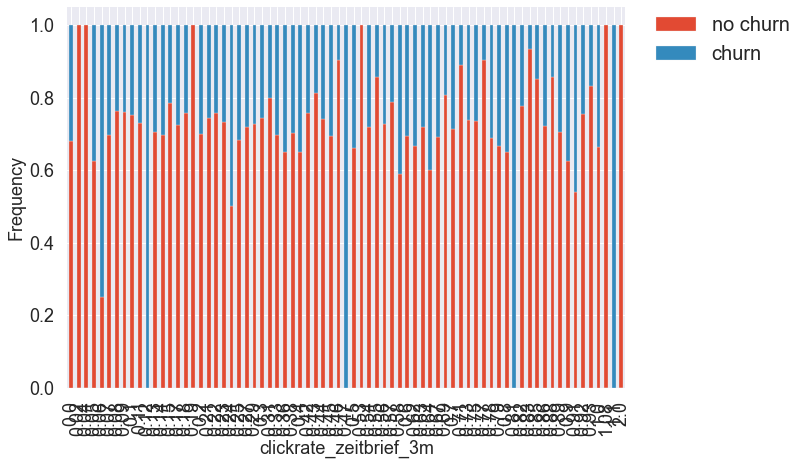

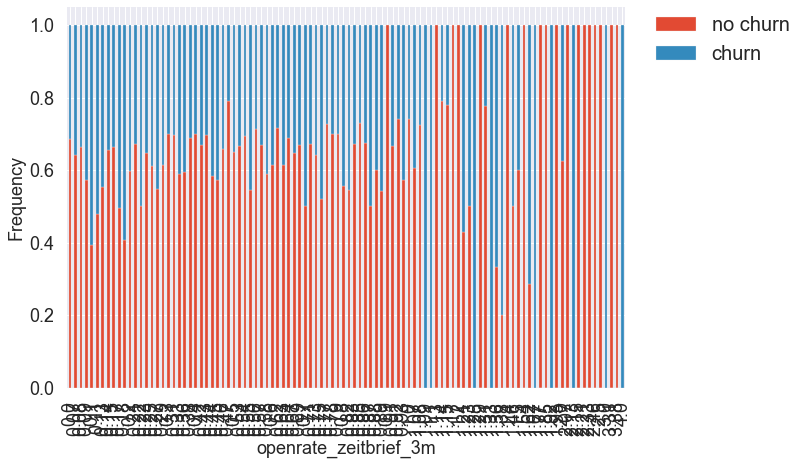

In [39]:
for i in ['received_anzahl_zeitbrief_6m', 'openedanzahl_zeitbrief_6m', 'clicked_anzahl_zeitbrief_6m', 'unsubscribed_anzahl_zeitbrief_6m', 'clickrate_zeitbrief_3m', 'openrate_zeitbrief_3m']:
    x = crosstab_evaluation(df[i],df.churn)
    crosstab_barplot(x,['no churn','churn'],xlabelname=i)

### zon (zone), cnt (count), reg (restricted areas) features

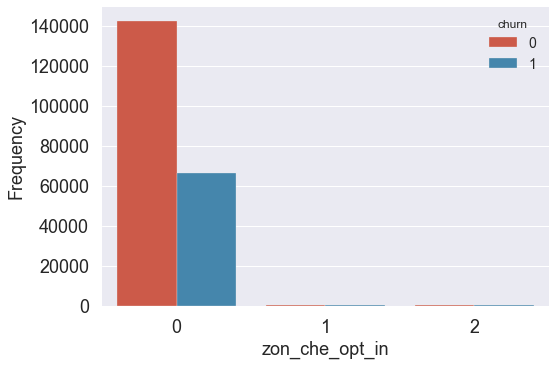

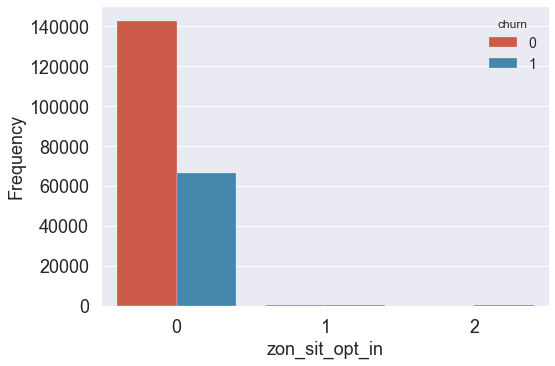

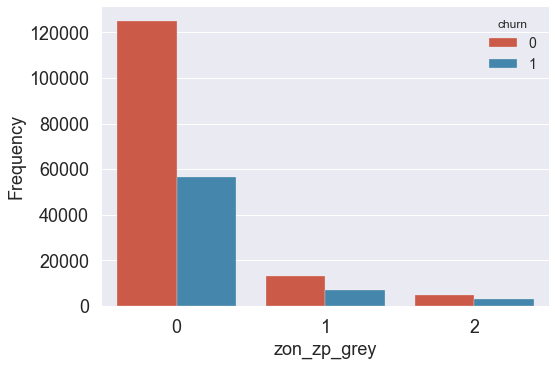

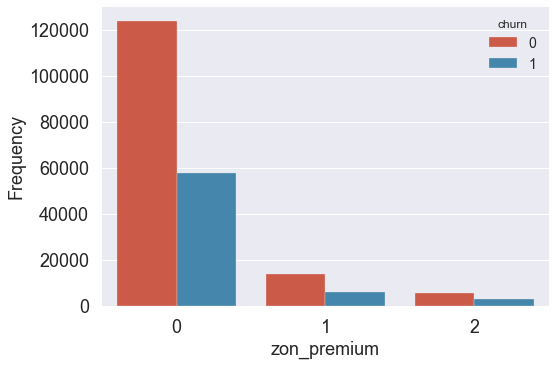

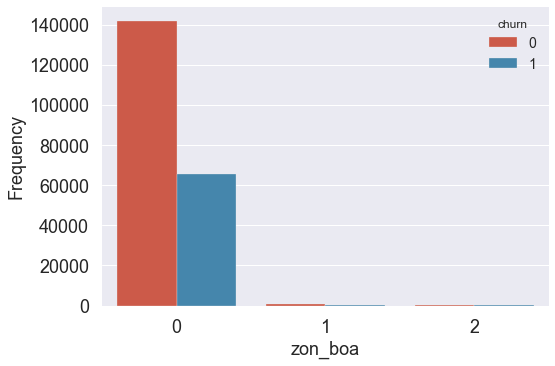

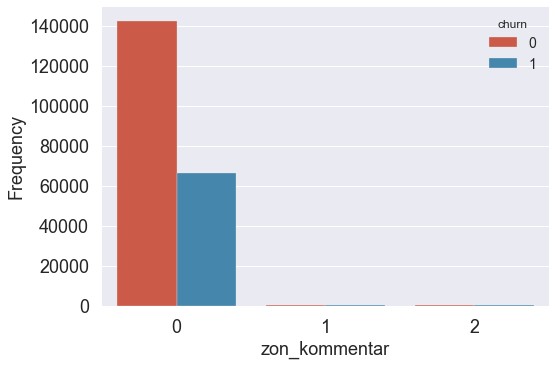

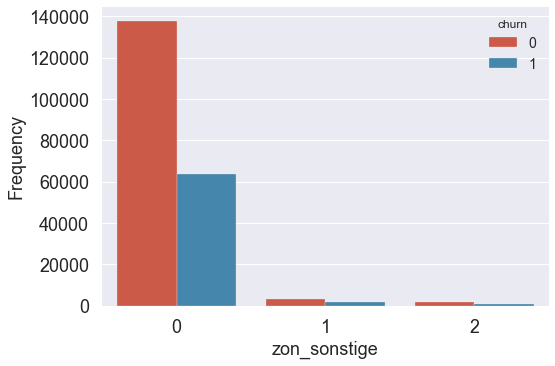

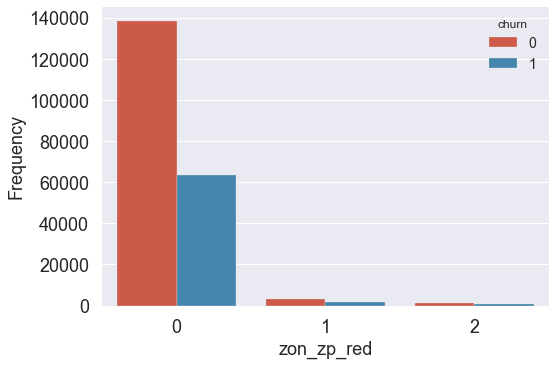

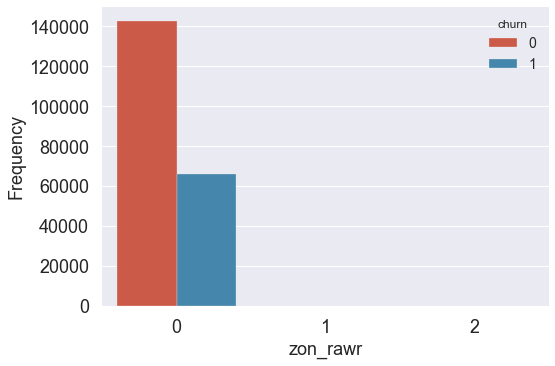

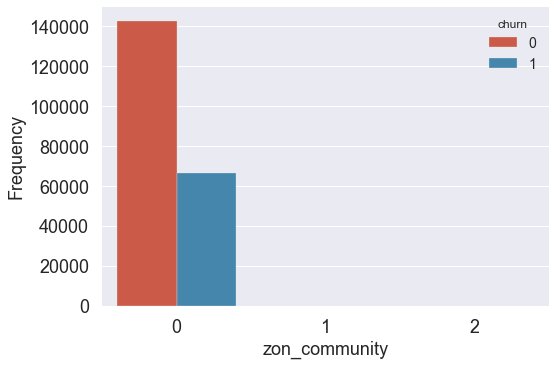

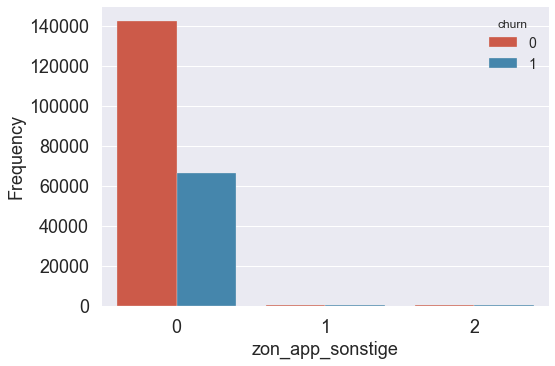

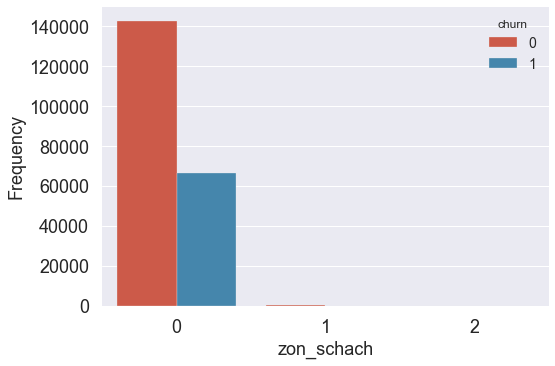

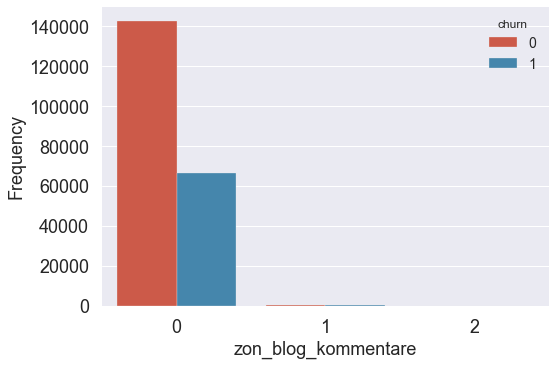

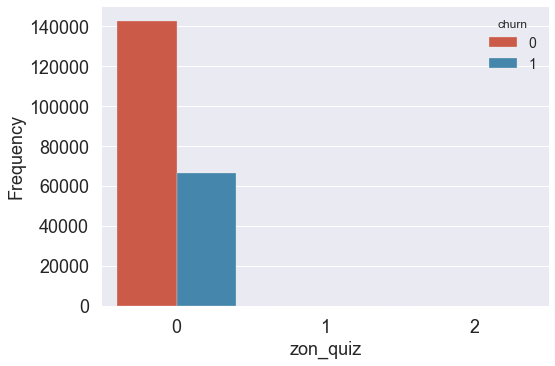

In [42]:
for elem in df_zon.columns:
    describe_frame = pd.DataFrame(round(df[elem].describe(),1))
    ax = sns.countplot(x=elem, data=continues, hue="churn")
    ax.set(xlabel=elem, ylabel="Frequency")
    plt.show()

In [43]:
def flatten_greater_0(flat):
    if flat > 0:
        return 1
    else:
        return 0
    
def flatten_greater_1(flat):
    if flat > 1:
        return 1
    else:
        return 0

In [45]:
print("Sum zon features")
for i in df_zon:
    df[i] = df[i].apply(flatten_greater_0)
print(df_zon.sum(axis=1).sample(5))
print("there are a few customers registred or active in more than one")
print("--------------------------------------------------------------")


print("Sum registrated for special areas features")
for i in df_zon:
    df[i] = df[i].apply(flatten_greater_1)
print(df_reg.sum(axis=1).sample(5))
print("there are a few customers registred or active in more than one")
print("--------------------------------------------------------------")


print("Sum newsletter feature")
df_nl.drop("nl_aktivitaet", axis=1, inplace=True)
for i in df_zon:
    df[i] = df[i].apply(flatten_greater_1)
print(df_nl.sum(axis=1).sample(5))
print("there are a few customers substribted to more than one newsletter")
print("--------------------------------------------------------------")


print("Registration to accses feature")
for i in df_reg:
    df[i] = df[i].apply(flatten_greater_1)
print(df_reg.sum(axis=1).sample(5))
print("this feature is less important a lot of customers never registred")
print("--------------------------------------------------------------")

Sum zon features
107243    0
25888     0
97425     0
76859     2
8034      0
dtype: int64
there are a few customers registred or active in more than one
--------------------------------------------------------------
Sum registrated for special areas features
121629    1
145535    2
154710    0
166661    1
3962      0
dtype: int64
there are a few customers registred or active in more than one
--------------------------------------------------------------
Sum newsletter feature


KeyError: "['nl_aktivitaet'] not found in axis"

**Observations:**
We will aggregate a few of the features. The zon_? features will becomme sum_zon so so we reduce the fetures 14 to 1. Same with the cnt_? features to sum_cnt (5:1) and the ?\_reg features which will be reduced to sum_rest_areas (4:1).

### Newsletter Email
Subscribers which are subscribed to an Newsletter online will be send emials. The number depends on the frequency of delivery of the newsletter. The Newsletter _Hamburg_ and the Newsletter _Zeitbiref_ are for example daily (Mo-Fr) Newsletter. For the purpose of our analysis it is only important if the subscriber becomes Email-Newsletter or not. <br>
Therefore, the following section is going to flatten thos columns into 1 and 0. 
* df_nl_bestandskunden
* df_nl_produktnews
* df_nl_hamburg
* df_nl_zeitbrief

In [49]:
for i in df_nl_bestandskunden:
    df[i] = df[i].apply(flatten_greater_0)
    
for i in df_nl_produktnews:
    df[i] = df[i].apply(flatten_greater_0)

for i in df_nl_hamburg:
    df[i] = df[i].apply(flatten_greater_0)
    
for i in df_zb:
    df[i] = df[i].apply(flatten_greater_0)

Furthermore we can obsereve the same pattern over all the different Newsletter: Only the ones which are not subscribed to an newsletter churn. Therefore the aggregation of the Newsletter is beeing considert. 

Plot vorher nachher (flatten)!

### Clickrate and Openrate Features

In [51]:
def flatten_rate(flat):
    if 0.75 < flat < 1:
        return 1
    elif 0 < flat < 0.25:
        return 0.25
    elif 0.25 < flat < 0.5:
        return 0.5
    elif 0.5 < flat < 0.75:
        return 0.75
    elif flat > 1:
        return 1.5
    else:
        return 0

In [52]:
for i in ['openrate_1w', 'clickrate_1w', 'openrate_1m', 'clickrate_1m', 'openrate_3m', 'clickrate_3m']:
    df[i] = df[i].apply(flatten_rate)

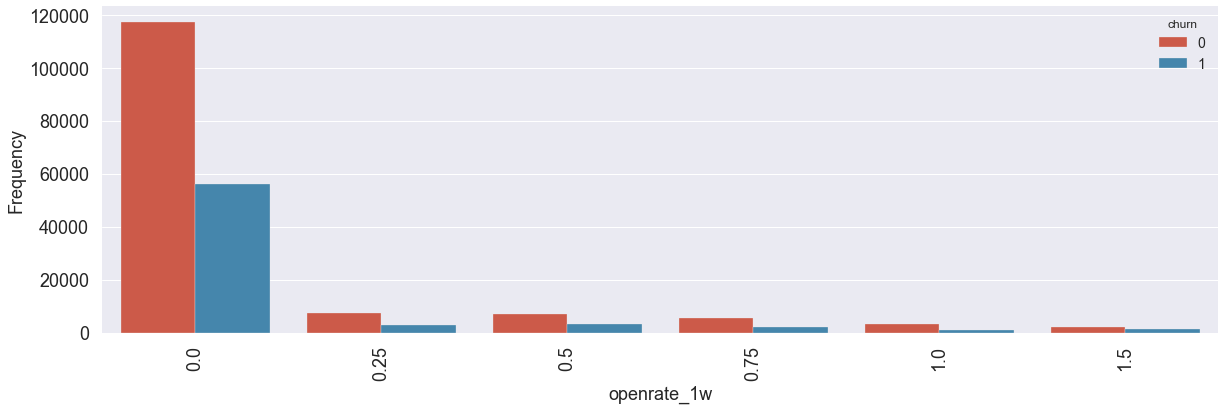

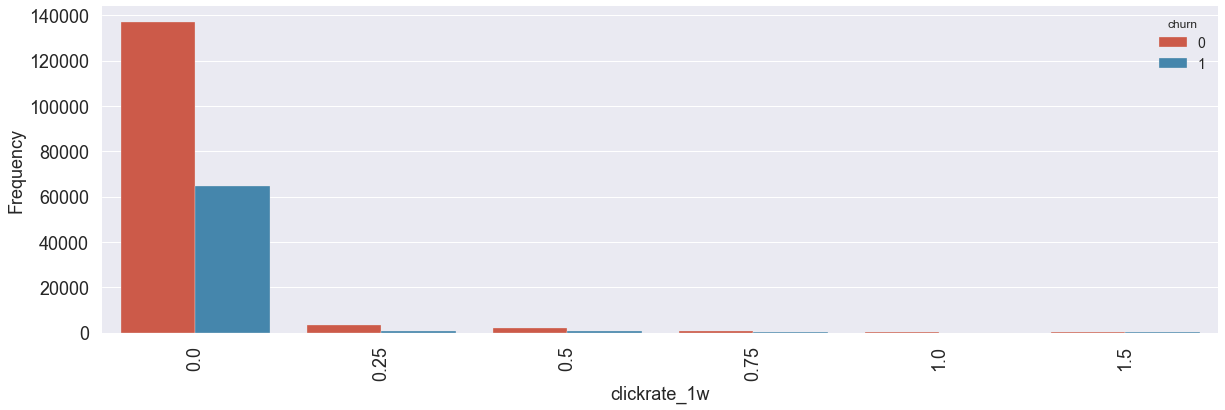

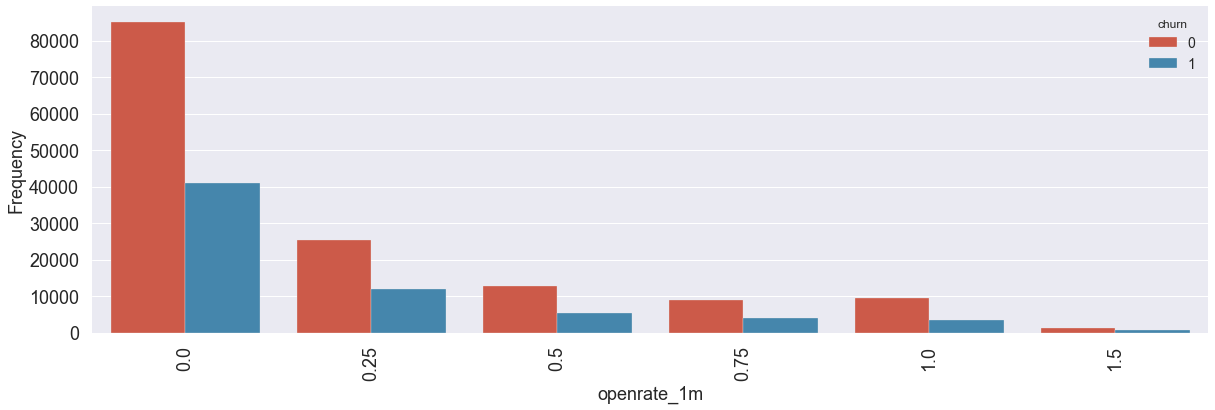

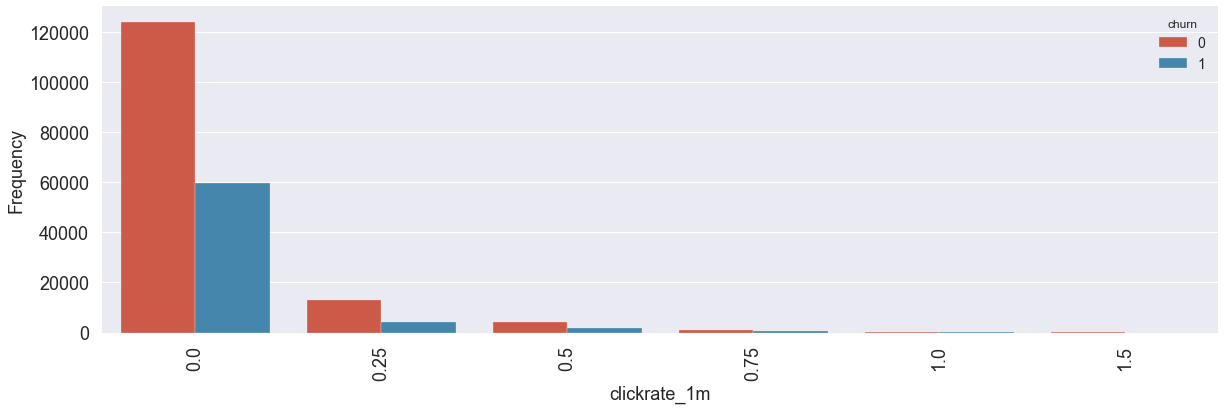

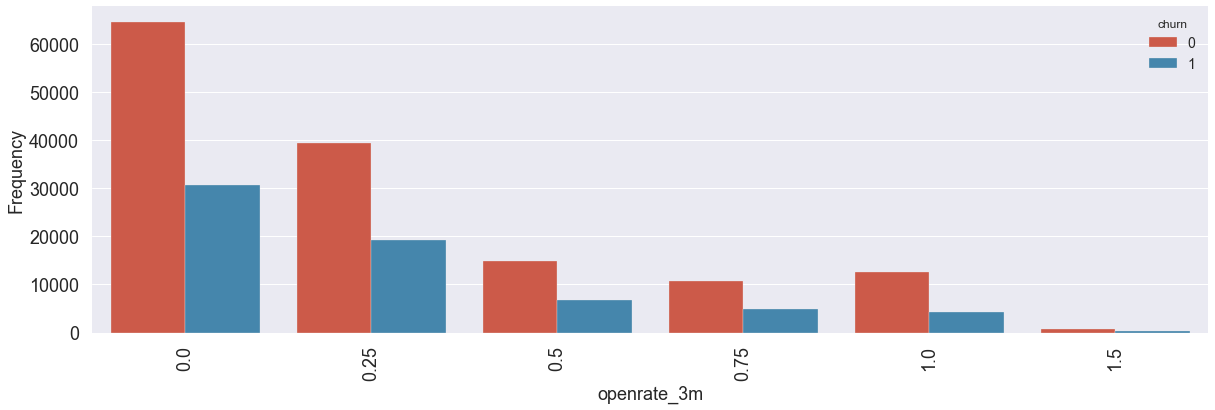

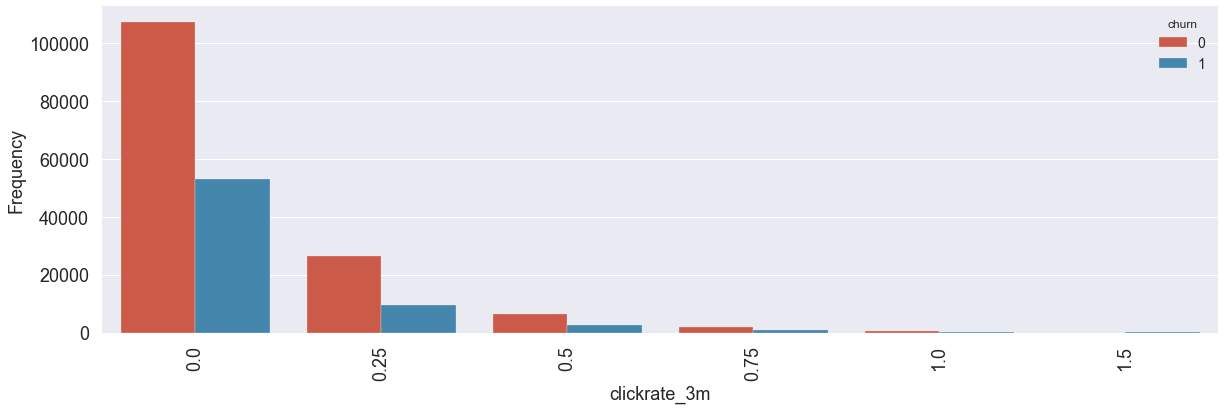

In [53]:
for i in ['openrate_1w', 'clickrate_1w', 'openrate_1m', 'clickrate_1m', 'openrate_3m', 'clickrate_3m']:
    

    plt.subplots(figsize=(20,6))
    ax = sns.countplot(x=i, hue='churn', data=df)
    ax.set(xlabel=i, ylabel='Frequency')

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

__Observations:__ To have an better overview of the clickrates we binned them into manageables rates (0,0.25,0.5,0.75,1 and 1.5 as a representative of all rates bigger than 1)

## Target Variable Analysis

Our target variable is "churn", which is 1 - churn or 0 - no churn. 

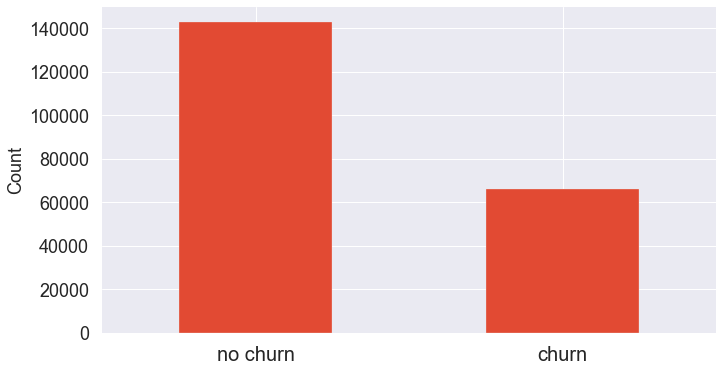

In [57]:
## Show the imbalance of churn target
df.churn.value_counts().plot(kind='bar',figsize=(11,6));
plt.ylabel('Count');
#plt.xlabel('Churn')
plt.xticks(np.arange(2), ('no churn', 'churn'),fontsize=20,rotation=0);

## Feature Analysis

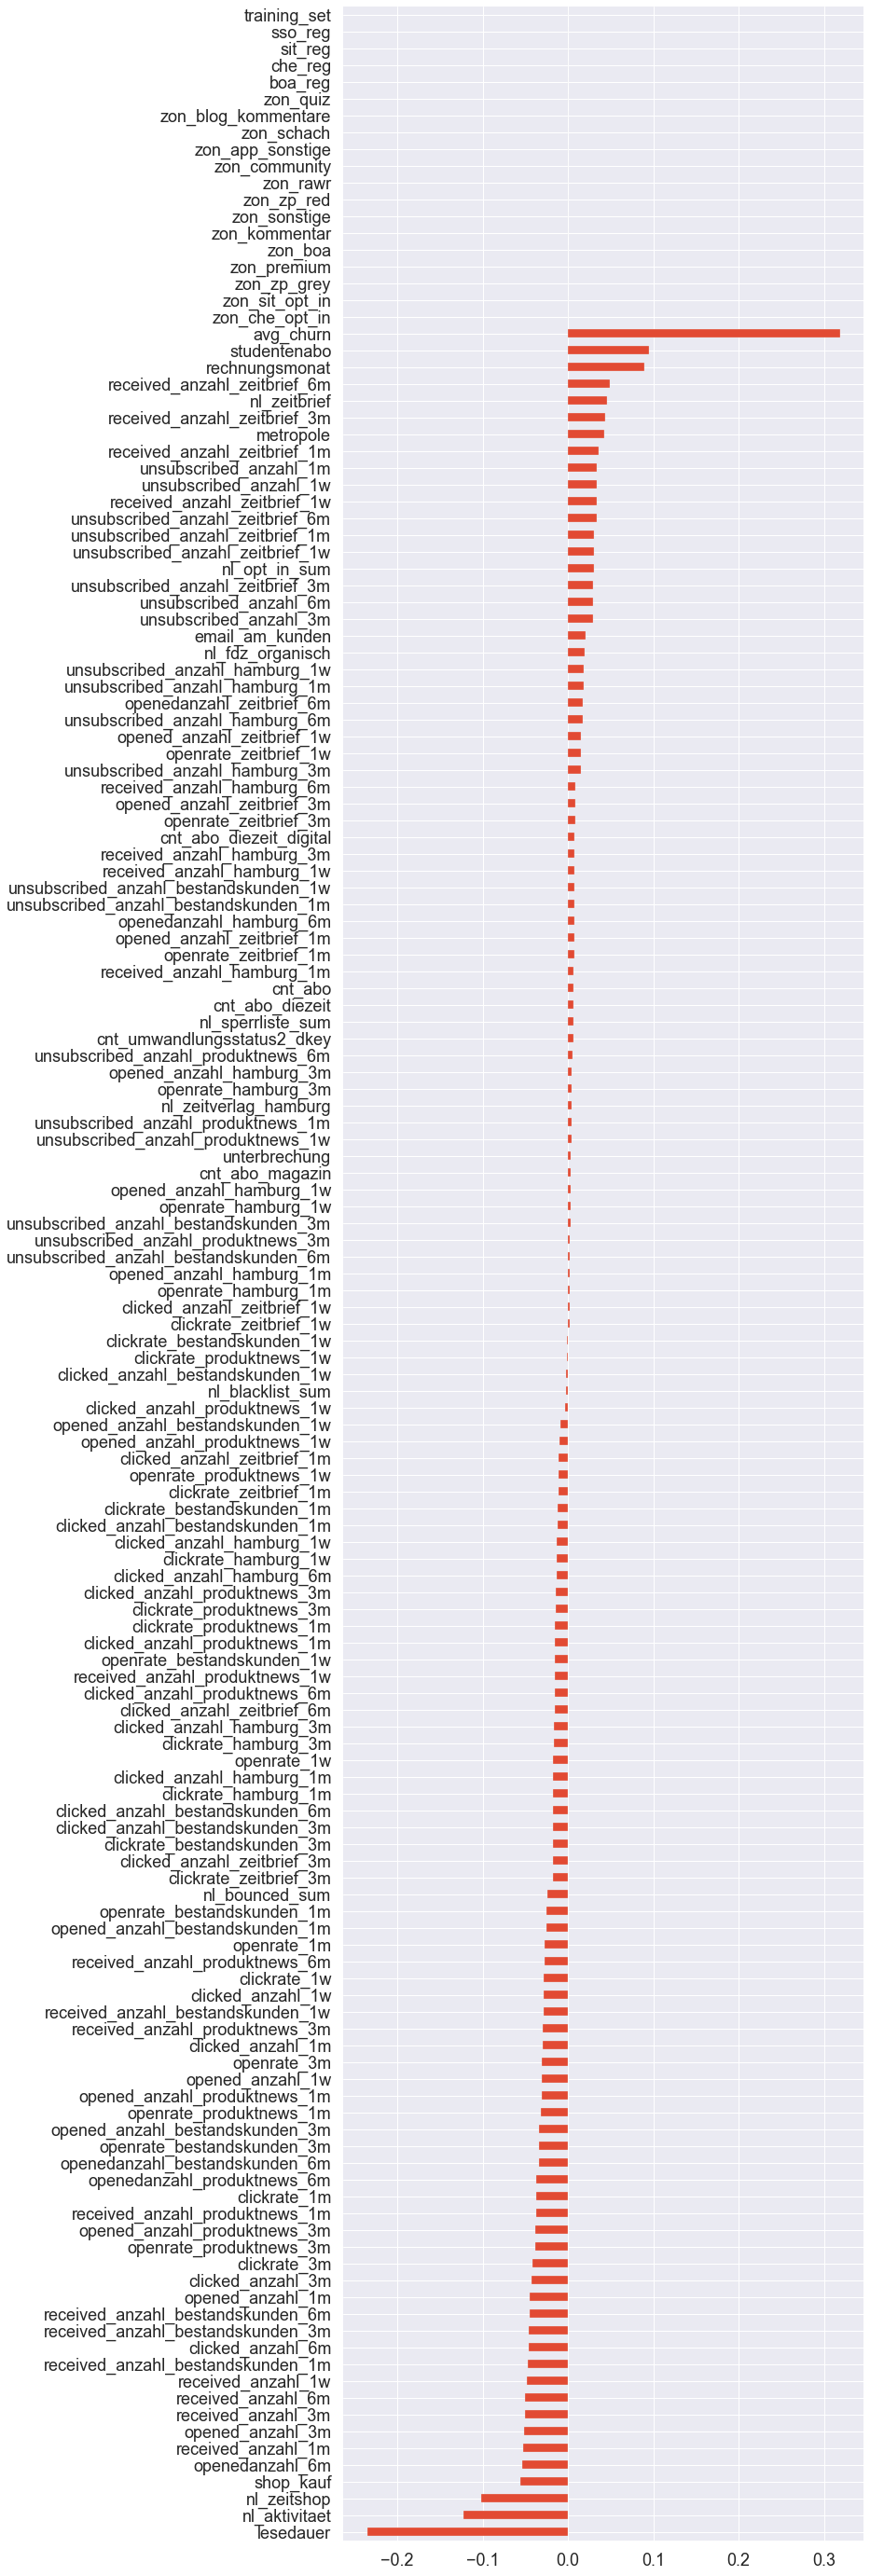

In [54]:
df.drop('churn', axis=1).corrwith(df.churn).sort_values().plot(kind='barh',figsize=(10, 50));

## Export the dataframe to .csv file

## Conclusion

# Feature Engineering

## ZON and reg features.

In [ ]:
# Silas: zon sum und reg_sum restr_a_sum join to dataframe

## Newsletter Flattening

In [69]:
# Carlotta: flattening of newletter data, sum and join.

## Time Features

In [ ]:
# - abo_registrierung_min_()

In [70]:
# lesedauer als alternative

In [71]:
# Welches ist das wichtigste time related feature?

## Dropping 

In [58]:
df.head(1)

,liefer_beginn_evt,kanal,objekt_name,aboform_name,zahlung_rhythmus_name,lesedauer,rechnungsmonat,zahlung_weg_name,studentenabo,plz_1,plz_2,plz_3,ort,metropole,land_iso_code,shop_kauf,unterbrechung,anrede,titel,avg_churn,email_am_kunden,zon_che_opt_in,zon_sit_opt_in,zon_zp_grey,zon_premium,zon_boa,zon_kommentar,zon_sonstige,zon_zp_red,zon_rawr,zon_community,zon_app_sonstige,zon_schach,zon_blog_kommentare,zon_quiz,cnt_abo,cnt_abo_diezeit,cnt_abo_diezeit_digital,cnt_abo_magazin,cnt_umwandlungsstatus2_dkey,abo_registrierung_min,nl_zeitbrief,nl_zeitshop,nl_zeitverlag_hamburg,nl_fdz_organisch,nl_blacklist_sum,nl_bounced_sum,nl_aktivitaet,nl_registrierung_min,nl_sperrliste_sum,nl_opt_in_sum,boa_reg,che_reg,sit_reg,sso_reg,received_anzahl_1w,received_anzahl_1m,received_anzahl_3m,received_anzahl_6m,opened_anzahl_1w,opened_anzahl_1m,opened_anzahl_3m,openedanzahl_6m,clicked_anzahl_1w,clicked_anzahl_1m,clicked_anzahl_3m,clicked_anzahl_6m,unsubscribed_anzahl_1w,unsubscribed_anzahl_1m,unsubscribed_anzahl_3m,unsubscribed_anzahl_6m,openrate_1w,clickrate_1w,openrate_1m,clickrate_1m,openrate_3m,clickrate_3m,received_anzahl_bestandskunden_1w,received_anzahl_bestandskunden_1m,received_anzahl_bestandskunden_3m,received_anzahl_bestandskunden_6m,opened_anzahl_bestandskunden_1w,opened_anzahl_bestandskunden_1m,opened_anzahl_bestandskunden_3m,openedanzahl_bestandskunden_6m,clicked_anzahl_bestandskunden_1w,clicked_anzahl_bestandskunden_1m,clicked_anzahl_bestandskunden_3m,clicked_anzahl_bestandskunden_6m,unsubscribed_anzahl_bestandskunden_1w,unsubscribed_anzahl_bestandskunden_1m,unsubscribed_anzahl_bestandskunden_3m,unsubscribed_anzahl_bestandskunden_6m,openrate_bestandskunden_1w,clickrate_bestandskunden_1w,openrate_bestandskunden_1m,clickrate_bestandskunden_1m,openrate_bestandskunden_3m,clickrate_bestandskunden_3m,received_anzahl_produktnews_1w,received_anzahl_produktnews_1m,received_anzahl_produktnews_3m,received_anzahl_produktnews_6m,opened_anzahl_produktnews_1w,opened_anzahl_produktnews_1m,opened_anzahl_produktnews_3m,openedanzahl_produktnews_6m,clicked_anzahl_produktnews_1w,clicked_anzahl_produktnews_1m,clicked_anzahl_produktnews_3m,clicked_anzahl_produktnews_6m,unsubscribed_anzahl_produktnews_1w,unsubscribed_anzahl_produktnews_1m,unsubscribed_anzahl_produktnews_3m,unsubscribed_anzahl_produktnews_6m,openrate_produktnews_1w,clickrate_produktnews_1w,openrate_produktnews_1m,clickrate_produktnews_1m,openrate_produktnews_3m,clickrate_produktnews_3m,received_anzahl_hamburg_1w,received_anzahl_hamburg_1m,received_anzahl_hamburg_3m,received_anzahl_hamburg_6m,opened_anzahl_hamburg_1w,opened_anzahl_hamburg_1m,opened_anzahl_hamburg_3m,openedanzahl_hamburg_6m,clicked_anzahl_hamburg_1w,clicked_anzahl_hamburg_1m,clicked_anzahl_hamburg_3m,clicked_anzahl_hamburg_6m,unsubscribed_anzahl_hamburg_1w,unsubscribed_anzahl_hamburg_1m,unsubscribed_anzahl_hamburg_3m,unsubscribed_anzahl_hamburg_6m,openrate_hamburg_1w,clickrate_hamburg_1w,openrate_hamburg_1m,clickrate_hamburg_1m,openrate_hamburg_3m,clickrate_hamburg_3m,received_anzahl_zeitbrief_1w,received_anzahl_zeitbrief_1m,received_anzahl_zeitbrief_3m,received_anzahl_zeitbrief_6m,opened_anzahl_zeitbrief_1w,opened_anzahl_zeitbrief_1m,opened_anzahl_zeitbrief_3m,openedanzahl_zeitbrief_6m,clicked_anzahl_zeitbrief_1w,clicked_anzahl_zeitbrief_1m,clicked_anzahl_zeitbrief_3m,clicked_anzahl_zeitbrief_6m,unsubscribed_anzahl_zeitbrief_1w,unsubscribed_anzahl_zeitbrief_1m,unsubscribed_anzahl_zeitbrief_3m,unsubscribed_anzahl_zeitbrief_6m,openrate_zeitbrief_1w,clickrate_zeitbrief_1w,openrate_zeitbrief_1m,clickrate_zeitbrief_1m,openrate_zeitbrief_3m,clickrate_zeitbrief_3m,training_set,kuendigungs_eingangs_datum,churn,date_x
0,2013-10-02,andere,ZEIT Digital,Probeabo,jährlich,68,0,Bankeinzug,0,6,64,647,Erbach,0,DE,4,0,Frau,akademischer Titel,0.133879,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2,0,2,2,2005-01-27 07:53:59,2,2,0,0,0,1,14,2005-09-30 00:00:00,0,0,0,0,0,0,6,14,43,80,4,15,38,74,1,2,2,2,0,0,0,0,0.75,0.0,1.5,0.25,1.0,0.25,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
droppinglist_obvious = ['training_set','avg_churn', 'kuendigungs_eingangs_datum', 'ort']

In [76]:
## list = rate und anzahl carlotta

In [62]:
droppinglist_cnt = list(df_cnt.columns[1:])

In [63]:
droppinglist_cnt

['cnt_abo_diezeit',
 'cnt_abo_diezeit_digital',
 'cnt_abo_magazin',
 'cnt_umwandlungsstatus2_dkey']

In [72]:
droppinglist_zon = list(df_zon.columns)

In [73]:
droppinglist_reg = list(df_reg.columns)

In [75]:
#droppinglist_tec = # bounces, blacklist etc. 

In [77]:
# time feature list = [] nl_reg_min, etc. 

## Conclusion and Comparison before after dropping and feature engineering

## Export final Dataframe

# Predictive Modelling

## Structure of the notebooks for machine learning

We used different jupyter notebook for different methods of machine learning. These notebooks are linked here:
    
- ...

- ...

- ...

- ...

# Data Visualization

The results and our main finding can be found in our presentation:

# Future Work

The aspects of future work can be found in our presentation. 